# **Tennis Performance Prediction**

https://colab.research.google.com/drive/1ICK9UUVJea5_XQJVRN399e5-L4bOTeut#scrollTo=1L_rLfwb9YWP

# **Introduction/Motivation**

Predicting the winner of a professional tennis match is far more complex than comparing player rankings. Match outcomes depend on multiple pre-match factors such as surface type, head-to-head history, recent form, playing style, and betting market expectations

This project aims to predict the winner of a professional tennis tournament using information available before the match, such as player rankings, surface type, head-to-head record, serve performance, and betting odds. The model will estimate whether Player 1 is likely to win or lose based on these factors.
Tennis outcomes depend on more than just skill or ranking as factors like surface preference, current form, handedness (whether a player is left or right-handed), and opponent history also play important roles. By analyzing these aspects together, we hope to understand which factors most influence a player’s chances of winning.

Tennis is full of assumptions, but the data tells a clearer story. By studying thousands of matches, this project identifies what truly affects who wins and loses. The goal is to replace guesses with fact-based insights that help players, coaches, and analysts make smarter decisions.

# **Load data**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    mean_squared_error,
    root_mean_squared_error,
    balanced_accuracy_score
)
from sklearn import set_config

set_config(display="diagram")

# Global random state used across all models
RANDOM_STATE = 42

# Download the merged tennis dataset (only needs to be run once)
!wget -q https://raw.githubusercontent.com/keen-25/BA810-13/main/Merged_Tennis_Data_.csv -O Merged_Tennis_Data_.csv

# Central data path and master dataframe
DATA_PATH = "Merged_Tennis_Data_.csv"

# Master copy of the dataset (do not modify this in cells below)
base_df = pd.read_csv(DATA_PATH)

df = base_df.copy()
merged_tennis = base_df.copy()
tennis_df = base_df.copy()

#Shared preprocessing / pipeline helpers

def make_preprocessor(categorical_features, numeric_features, scale_numeric: bool = True):
    numeric_transformer = StandardScaler() if scale_numeric else "passthrough"
    return ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", numeric_transformer, numeric_features),
        ]
    )


def make_pipeline(model, categorical_features, numeric_features, scale_numeric: bool = True):
    preprocessor = make_preprocessor(categorical_features, numeric_features, scale_numeric)
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model),
        ]
    )
    return pipe


base_df.head()

/tmp/ipython-input-2460080848.py:32: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv(DATA_PATH)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,PSW,PSL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL
0,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Gasquet R.,...,1.526,2.740,1.500,2.500,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Odesnik W.,...,2.140,1.813,2.250,1.571,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Gicquel M.,...,1.676,2.360,1.615,2.200,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Falla A.,...,2.580,1.581,2.500,1.500,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Levy H.,...,2.170,1.787,3.000,1.333,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_path = "Merged_Tennis_Data_.csv"

df = pd.read_csv(data_path)
df.head()

/tmp/ipython-input-3125882898.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,PSW,PSL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL
0,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Gasquet R.,...,1.526,2.740,1.500,2.500,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Odesnik W.,...,2.140,1.813,2.250,1.571,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Gicquel M.,...,1.676,2.360,1.615,2.200,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Falla A.,...,2.580,1.581,2.500,1.500,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Brisbane,Brisbane International,1/4/10,ATP250,Outdoor,Hard,1st Round,3.0,Levy H.,...,2.170,1.787,3.000,1.333,NaN,NaN,NaN,NaN,NaN,NaN


## Quick overview of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40766 entries, 0 to 40765
Data columns (total 44 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         40766 non-null  int64  
 1   Location    40766 non-null  object 
 2   Tournament  40766 non-null  object 
 3   Date        40766 non-null  object 
 4   Series      40766 non-null  object 
 5   Court       40766 non-null  object 
 6   Surface     40766 non-null  object 
 7   Round       40766 non-null  object 
 8   Best of     40751 non-null  float64
 9   Winner      40766 non-null  object 
 10  Loser       40766 non-null  object 
 11  WRank       40752 non-null  float64
 12  LRank       40688 non-null  float64
 13  WPts        40754 non-null  float64
 14  LPts        40689 non-null  float64
 15  W1          40495 non-null  float64
 16  L1          40498 non-null  float64
 17  W2          40139 non-null  float64
 18  L2          40138 non-null  float64
 19  W3          19354 non-nul

In [ ]:
print("What type of data are stored in the columns:")
tennis_df.info()

print("\nSummary statistics of numeric columns:")
tennis_df.describe()

print("\nSummary statistics of categorical columns:")
tennis_df.describe(include='object')

What type of data are stored in the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40766 entries, 0 to 40765
Data columns (total 44 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         40766 non-null  int64  
 1   Location    40766 non-null  object 
 2   Tournament  40766 non-null  object 
 3   Date        40766 non-null  object 
 4   Series      40766 non-null  object 
 5   Court       40766 non-null  object 
 6   Surface     40766 non-null  object 
 7   Round       40766 non-null  object 
 8   Best of     40751 non-null  float64
 9   Winner      40766 non-null  object 
 10  Loser       40766 non-null  object 
 11  WRank       40752 non-null  float64
 12  LRank       40688 non-null  float64
 13  WPts        40754 non-null  float64
 14  LPts        40689 non-null  float64
 15  W1          40495 non-null  float64
 16  L1          40498 non-null  float64
 17  W2          40139 non-null  float64
 18  L2          40138 non

,Location,Tournament,Date,Series,Court,Surface,Round,Winner,Loser,Comment,EXW
count,40766,40766,40766,40766,40766,40766,40766,40766,40766,40766,23463
unique,112,170,4437,5,2,3,8,741,1102,7,437
top,Paris,Australian Open,1/19/10,ATP250,Outdoor,Hard,1st Round,Djokovic N.,Mannarino A.,Completed,1.35
freq,2832,2032,53,17100,33619,23472,18237,860,346,39248,639


In [ ]:
cols_to_drop = [
    'pl2_hand', 'pl1_hand', 'pl1_flag', 'pl2_flag',
    'EXW', 'Comment', 'Loser', 'Winner', 'Round',
    'Surface', 'Court', 'Series', 'Date',
    'Tournament', 'Location'
]

tennis_data_drop = tennis_df.drop(columns=cols_to_drop, errors='ignore')
tennis_data_drop.corr()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W2,L2,...,PSW,PSL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL
ATP,1.000000,-0.040489,-0.027410,-0.027192,0.039589,0.067437,0.009436,0.020170,0.004595,0.009203,...,0.009747,-0.028954,0.024544,-0.040632,0.007488,0.004527,0.006307,-0.027212,-0.004080,-0.090968
Best of,-0.040489,1.000000,-0.072479,-0.007477,0.137791,0.002008,-0.024740,-0.003949,-0.026348,0.021997,...,-0.022854,0.238370,-0.044436,0.227848,-0.018042,0.018970,-0.028770,0.264474,-0.032874,0.235336
WRank,-0.027410,-0.072479,1.000000,0.099910,-0.429294,-0.122914,-0.035244,0.043838,-0.033147,0.035192,...,0.279294,-0.232025,0.319788,-0.289874,0.266259,-0.009116,0.243463,-0.279393,0.288970,-0.257448
LRank,-0.027192,-0.007477,0.099910,1.000000,-0.129346,-0.357367,0.010365,-0.054563,0.022770,-0.051075,...,-0.181060,0.156936,-0.216974,0.160571,-0.170633,0.000904,-0.158920,0.195105,-0.183063,0.160357
WPts,0.039589,0.137791,-0.429294,-0.129346,1.000000,0.229053,0.036712,-0.090144,0.041887,-0.069291,...,-0.251322,0.555969,-0.283928,0.623734,-0.236092,0.014362,-0.221833,0.606924,-0.279862,0.628070
LPts,0.067437,0.002008,-0.122914,-0.357367,0.229053,1.000000,-0.024252,0.057895,-0.025623,0.063664,...,0.429794,-0.144439,0.447014,-0.151198,0.417917,-0.004106,0.353208,-0.177541,0.496685,-0.073164
W1,0.009436,-0.024740,-0.035244,0.010365,0.036712,-0.024252,1.000000,-0.177640,-0.117093,0.052298,...,-0.054575,0.045195,-0.050087,0.052781,-0.052601,0.001963,-0.049022,0.053266,-0.097797,0.053514
L1,0.020170,-0.003949,0.043838,-0.054563,-0.090144,0.057895,-0.177640,1.000000,0.091878,0.032477,...,0.105130,-0.153525,0.117382,-0.168334,0.099193,-0.005435,0.089019,-0.169693,0.123431,-0.179202
W2,0.004595,-0.026348,-0.033147,0.022770,0.041887,-0.025623,-0.117093,0.091878,1.000000,-0.134883,...,-0.060708,0.045990,-0.062275,0.058173,-0.055637,-0.009365,-0.048758,0.056058,-0.009106,0.046167
L2,0.009203,0.021997,0.035192,-0.051075,-0.069291,0.063664,0.052298,0.032477,-0.134883,1.000000,...,0.100018,-0.126202,0.107734,-0.136325,0.093877,-0.002231,0.089134,-0.138412,0.068520,-0.118745


# **Exploratory Data Analysis**

## Theme 1: Player-Level Predictive Factors

In this section we explore how player-level attributes such as ranking and ATP points relate to match outcomes.

### How Strongly Does Ranking Predict Outcome? (by Surface)

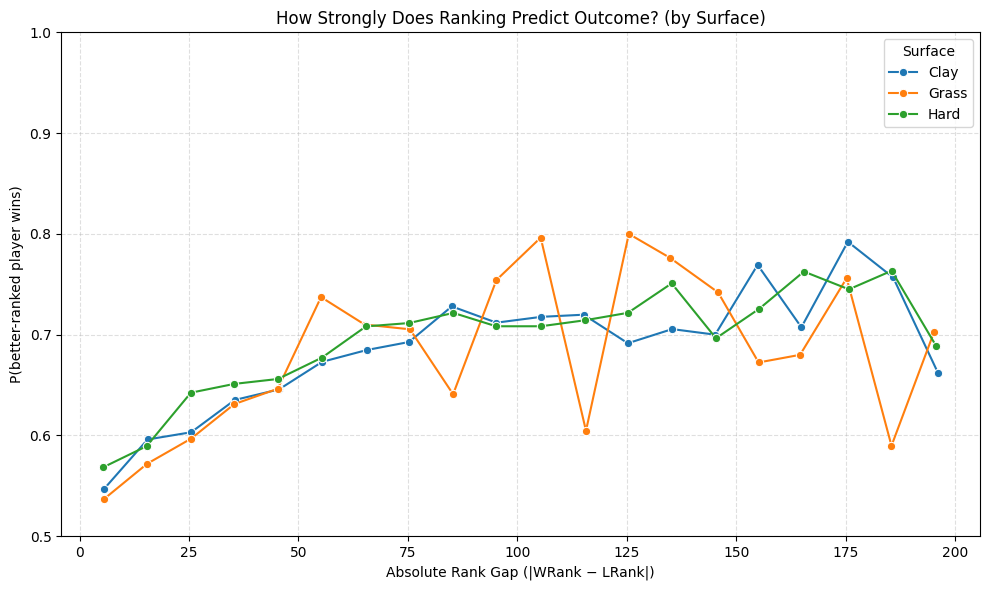

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_rank = tennis_df.dropna(subset=['WRank', 'LRank', 'Surface']).copy()

# rank_gap = absolute difference in rankings between winner & loser
df_rank['rank_gap'] = (df_rank['WRank'] - df_rank['LRank']).abs()

df_rank['better_rank_won'] = (df_rank['WRank'] < df_rank['LRank']).astype(int)

bins = np.arange(0, 210, 10)
df_rank['rank_bin'] = pd.cut(df_rank['rank_gap'], bins=bins, include_lowest=True)

rank_calib = (
    df_rank
    .groupby(['Surface', 'rank_bin'], observed=False)
    .agg(
        win_rate=('better_rank_won', 'mean'),
        n=('better_rank_won', 'size'),
        rank_gap_mid=('rank_gap', 'mean')
    )
    .dropna(subset=['rank_gap_mid'])
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=rank_calib,
    x='rank_gap_mid',
    y='win_rate',
    hue='Surface',
    marker='o'
)

plt.xlabel("Absolute Rank Gap (|WRank − LRank|)")
plt.ylabel("P(better-ranked player wins)")
plt.title("How Strongly Does Ranking Predict Outcome? (by Surface)")
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Surface")
plt.tight_layout()
plt.show()

As the **absolute rank gap increases**, the higher-ranked player wins **more often**.
- On **hard courts**, ranking is the most reliable: big rank gaps translate into very high win rates.
- On **clay**, the curve is flatter → ranking is **noisier** and upsets are more common.
- **Grass** sits in between: more predictable than clay, slightly less than hard.
- Even for **small rank gaps (< 10)**, the better-ranked player wins well above **50%**, confirming that ATP ranking is a **strong but not perfect** predictor of match outcome.

### **ATP points gap vs “better-points player wins”**

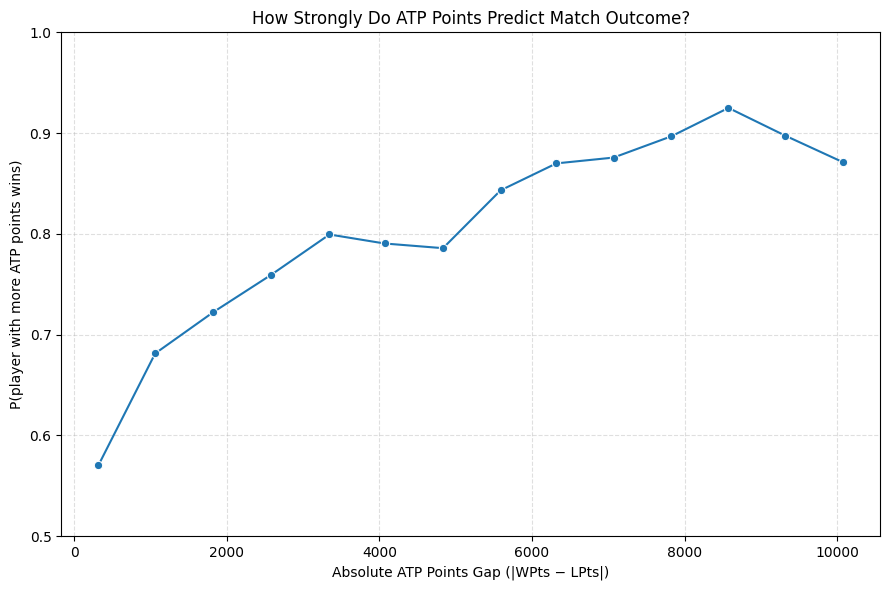

In [ ]:
df_pts = tennis_df.dropna(subset=['WPts', 'LPts']).copy()

df_pts['pts_gap'] = (df_pts['WPts'] - df_pts['LPts']).abs()
df_pts['better_pts_won'] = (df_pts['WPts'] > df_pts['LPts']).astype(int)

bins = np.linspace(0, df_pts['pts_gap'].quantile(0.99), 15)
df_pts['pts_bin'] = pd.cut(df_pts['pts_gap'], bins=bins, include_lowest=True)

pts_calib = (
    df_pts
    .groupby('pts_bin', observed=False)
    .agg(
        win_rate=('better_pts_won', 'mean'),
        pts_gap_mid=('pts_gap', 'mean'),
        n=('better_pts_won', 'size')
    )
    .dropna(subset=['pts_gap_mid'])
    .reset_index()
)

plt.figure(figsize=(9, 6))
sns.lineplot(
    data=pts_calib,
    x='pts_gap_mid',
    y='win_rate',
    marker='o'
)
plt.xlabel("Absolute ATP Points Gap (|WPts − LPts|)")
plt.ylabel("P(player with more ATP points wins)")
plt.title("How Strongly Do ATP Points Predict Match Outcome?")
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Key takeaways:**
- The probability that the player with **more ATP points** wins rises steadily with the **points gap**.
- For **large ATP points gaps**, the win rate of the higher-points player approaches **80–90%**, showing very strong predictive power.
- The relationship is smoother than with rank, since ATP points capture **performance on a continuous scale**.
- This supports using ATP points (alone or with ranking) as a **core feature** in our prediction model.

### **Winner ranking & ATP points in Bo3 vs Bo5**

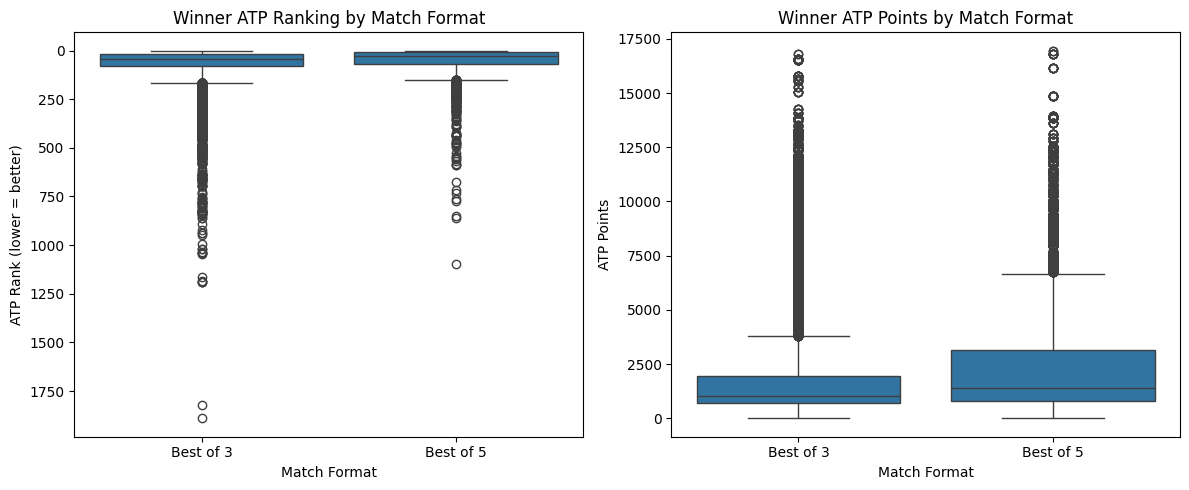

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only matches with known "Best of" and winner stats
q3 = tennis_df.dropna(subset=['Best of', 'WRank', 'WPts']).copy()
q3 = q3[q3['Best of'].isin([3, 5])]

# Make it clearer for plotting
q3['Format'] = q3['Best of'].map({3: 'Best of 3', 5: 'Best of 5'})

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=q3, x='Format', y='WRank')
plt.gca().invert_yaxis()  # lower rank = better
plt.title("Winner ATP Ranking by Match Format")
plt.ylabel("ATP Rank (lower = better)")
plt.xlabel("Match Format")

plt.subplot(1, 2, 2)
sns.boxplot(data=q3, x='Format', y='WPts')
plt.title("Winner ATP Points by Match Format")
plt.ylabel("ATP Points")
plt.xlabel("Match Format")

plt.tight_layout()
plt.show()


 Winners of **Best-of-5** matches tend to be **higher-ranked (lower rank number)** than winners of Best-of-3.
- They also have **higher ATP points**, indicating stronger long-term performance.
- This shows that longer matches **reward consistency, stamina, and overall quality** – the better player has more time to assert their edge.
- In contrast, **Best-of-3** matches leave more room for volatility and upsets, since a short hot streak can decide the match.

## Theme 2: Betting Market Calibration & Mispricing

Here we study whether betting markets misestimate the true probabilities of favorites and underdogs, and whether there are systematic value opportunities.

### **Do betting odds systematically under/overestimate upset probabilities?**

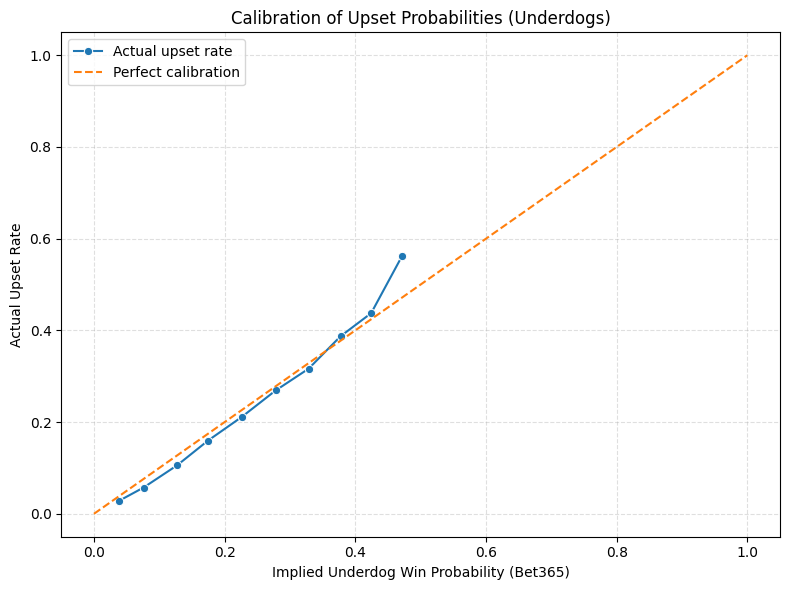

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

q2 = tennis_df.dropna(subset=['B365W', 'B365L']).copy()

# Raw implied probabilities from decimal odds
q2['imp_w_raw'] = 1 / q2['B365W']
q2['imp_l_raw'] = 1 / q2['B365L']

# Remove bookmaker overround
total = q2['imp_w_raw'] + q2['imp_l_raw']
q2['imp_w'] = q2['imp_w_raw'] / total
q2['imp_l'] = q2['imp_l_raw'] / total

# Identify favorite & underdog implied probs
q2['fav_imp_prob'] = q2[['imp_w', 'imp_l']].max(axis=1)
q2['dog_imp_prob'] = q2[['imp_w', 'imp_l']].min(axis=1)

# "is_upset" = 1 if favorite loses
q2['favorite_won'] = (q2['B365W'] < q2['B365L']).astype(int)
q2['is_upset'] = 1 - q2['favorite_won']

# Bin underdog implied probability
bins = np.arange(0, 1.05, 0.05)
q2['dog_prob_bin'] = pd.cut(q2['dog_imp_prob'], bins=bins, include_lowest=True)

upset_calib = (
    q2
    .groupby('dog_prob_bin', observed=False)
    .agg(
        implied_underdog_prob=('dog_imp_prob', 'mean'),
        actual_upset_rate=('is_upset', 'mean'),
        n=('is_upset', 'size')
    )
    .dropna(subset=['implied_underdog_prob'])
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=upset_calib,
    x='implied_underdog_prob',
    y='actual_upset_rate',
    marker='o',
    label='Actual upset rate'
)
plt.plot([0, 1], [0, 1], '--', label='Perfect calibration')

plt.xlabel("Implied Underdog Win Probability (Bet365)")
plt.ylabel("Actual Upset Rate")
plt.title("Calibration of Upset Probabilities (Underdogs)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


**Key takeaways:**
- When we group matches by the **implied underdog probability**, the **actual upset rate** is usually **slightly above** what the odds suggest.
- This means **underdogs win a bit more often** than the market expects → markets **underestimate upset chances**.
- The curve is still close to the 45° line, so Bet365 is **quite well calibrated overall**.
- The small but consistent gap points to a **mild underdog-value bias** that could be exploitable.

### **Do betting markets systematically overestimate favorites or underestimate underdogs?**

In [ ]:
# Use Bet365 odds
w_col, l_col = 'B365W', 'B365L'

df1 = df.dropna(subset=[w_col, l_col]).copy()

df1['imp_w_raw'] = 1 / df1[w_col]
df1['imp_l_raw'] = 1 / df1[l_col]

overround = df1['imp_w_raw'] + df1['imp_l_raw']
df1['imp_w'] = df1['imp_w_raw'] / overround
df1['imp_l'] = df1['imp_l_raw'] / overround

# Identify favorite & underdog
df1['fav_imp_prob'] = df1[['imp_w', 'imp_l']].max(axis=1)
df1['dog_imp_prob'] = df1[['imp_w', 'imp_l']].min(axis=1)

df1['favorite_won'] = (df1[w_col] < df1[l_col]).astype(int)
df1['is_upset'] = 1 - df1['favorite_won']

print("Bet365 — Favorites")
print("Implied Win Prob:", round(df1['fav_imp_prob'].mean(), 3))
print("Actual Win Rate:", round(df1['favorite_won'].mean(), 3))

print("\nBet365 — Underdogs")
print("Implied Underdog Prob:", round(df1['dog_imp_prob'].mean(), 3))
print("Actual Underdog Win Rate:", round(df1['is_upset'].mean(), 3))


Bet365 — Favorites
Implied Win Prob: 0.689
Actual Win Rate: 0.682

Bet365 — Underdogs
Implied Underdog Prob: 0.311
Actual Underdog Win Rate: 0.318


Key Takeaways:

* Bet365’s tennis odds are exceptionally well-calibrated.
Favorites win almost exactly as often as their implied probability suggests, and the same holds for underdogs.

* There is a very small favorite-overpricing bias (favorites win 0.7% less than implied), and a corresponding underdog underpricing bias (underdogs win 0.7% more than implied), but these effects are marginal.


The tennis betting market is highly efficient, with only slight evidence of the classic favorite–longshot bias.

### **How accurate are implied probabilities from betting odds compared to actual outcomes?**

In [ ]:
b365 = tennis_df.dropna(subset=['B365W', 'B365L', 'Surface']).copy()

b365['imp_w_raw'] = 1 / b365['B365W']
b365['imp_l_raw'] = 1 / b365['B365L']

total = b365['imp_w_raw'] + b365['imp_l_raw']
b365['imp_w'] = b365['imp_w_raw'] / total
b365['imp_l'] = b365['imp_l_raw'] / total

b365['fav_imp_prob'] = b365[['imp_w', 'imp_l']].max(axis=1)
b365['dog_imp_prob'] = b365[['imp_w', 'imp_l']].min(axis=1)

b365['favorite_won'] = (b365['B365W'] < b365['B365L']).astype(int)
b365['is_upset'] = 1 - b365['favorite_won']

cal = b365.dropna(subset=['fav_imp_prob', 'favorite_won']).copy()


cal['prob_bin'] = pd.cut(cal['fav_imp_prob'],
                         bins=np.arange(0, 1.05, 0.05),
                         include_lowest=True)


calib_fav = (
    cal
    .groupby('prob_bin', observed=False)
    .agg(
        implied_prob=('fav_imp_prob', 'mean'),
        actual_win_rate=('favorite_won', 'mean'),
        n=('favorite_won', 'size')
    )
    .reset_index()
)

calib_fav.head(10)

,prob_bin,implied_prob,actual_win_rate,n
0,"(-0.001, 0.05]",NaN,NaN,0
1,"(0.05, 0.1]",NaN,NaN,0
2,"(0.1, 0.15]",NaN,NaN,0
3,"(0.15, 0.2]",NaN,NaN,0
4,"(0.2, 0.25]",NaN,NaN,0
5,"(0.25, 0.3]",NaN,NaN,0
6,"(0.3, 0.35]",NaN,NaN,0
7,"(0.35, 0.4]",NaN,NaN,0
8,"(0.4, 0.45]",NaN,NaN,0
9,"(0.45, 0.5]",0.5,0.0,885


In [ ]:
from sklearn.metrics import brier_score_loss
brier_b365 = brier_score_loss(cal['favorite_won'], cal['fav_imp_prob'])
print("Bet365 – Brier score (favorite win prob):", round(brier_b365, 4))


Bet365 – Brier score (favorite win prob): 0.1968


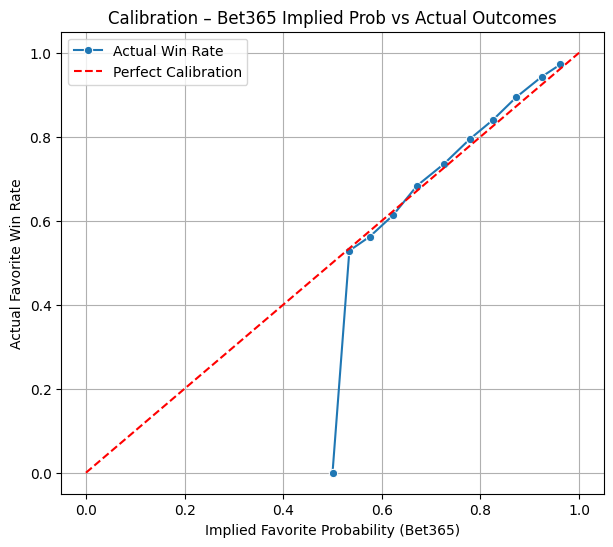

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

#actual calibration curve
sns.lineplot(
    data=calib_fav,
    x='implied_prob',
    y='actual_win_rate',
    marker='o',
    label='Actual Win Rate'
)

#perfect calibration reference line
plt.plot([0, 1], [0, 1],
         '--',
         color='red',
         label='Perfect Calibration')

plt.xlabel("Implied Favorite Probability (Bet365)")
plt.ylabel("Actual Favorite Win Rate")
plt.title("Calibration – Bet365 Implied Prob vs Actual Outcomes")
plt.grid(True)
plt.legend()

plt.show()



Key Takeaways:

* Bet365's implied probabilities are nearly perfectly calibrated with actual match outcomes.

* A lone unstable bin reflects low sample size, not systemic bias.

* Strong favorites actually perform slightly better than odds predict.

* Plot confirms high market efficiency and sets expectations appropriately for ML modeling.

### **Are there consistent value bets, underdogs winning more than implied?**

In [ ]:
dog_df = b365[['dog_imp_prob', 'is_upset']].copy()

dog_df['prob_bin'] = pd.cut(dog_df['dog_imp_prob'], bins=np.arange(0, 1.05, 0.05))

value_bins = (
    dog_df
    .groupby('prob_bin')
    .agg(
        n=('is_upset', 'size'),
        mean_implied=('dog_imp_prob', 'mean'),
        actual_win_rate=('is_upset', 'mean')
    )
    .dropna()
)

value_bins['excess'] = value_bins['actual_win_rate'] - value_bins['mean_implied']

value_bins.query("n >= 40 and excess > 0.05") \
          .sort_values('excess', ascending=False)


/tmp/ipython-input-879808253.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('prob_bin')


,n,mean_implied,actual_win_rate,excess
prob_bin,,,,
"(0.45, 0.5]",5116,0.471774,0.562744,0.090971


Key Takeaways:

* Underdogs priced with a 45–50% implied chance (close matches where odds are nearly even) win about 9% more often than bookmakers predict.

* This is a substantial and systematic underestimation of underdogs by the market.

## Theme 3: Bookmaker Comparison

We compare different odds sources to see which bookmaker provides the most accurate and best-calibrated probabilities.

### **Which books are most accurate? (Brier score viz)**

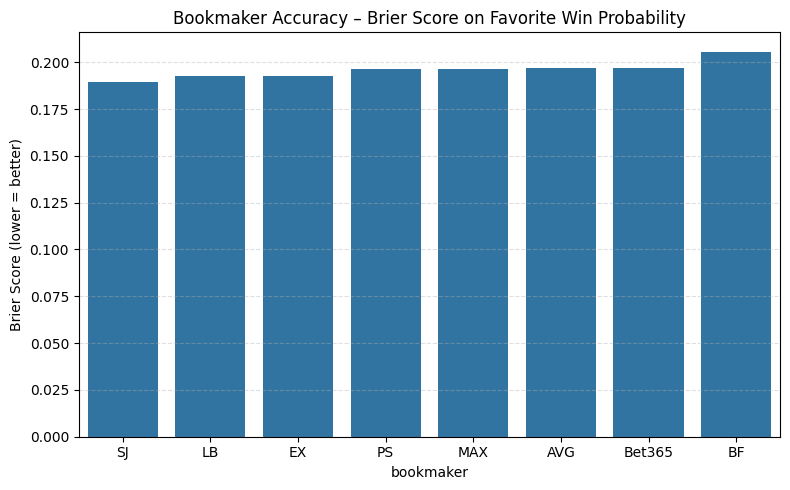

,bookmaker,brier_score,matches
4,SJ,0.189615,12903
2,LB,0.192436,22770
1,EX,0.192648,23440
3,PS,0.196420,40443
5,MAX,0.196600,39777
6,AVG,0.196876,39776
0,Bet365,0.196903,40546
7,BF,0.205682,651


In [ ]:
from sklearn.metrics import brier_score_loss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bookmakers = {
    'Bet365': ('B365W', 'B365L'),
    'EX':     ('EXW',  'EXL'),
    'LB':     ('LBW',  'LBL'),
    'PS':     ('PSW',  'PSL'),
    'SJ':     ('SJW',  'SJL'),
    'MAX':    ('MaxW', 'MaxL'),
    'AVG':    ('AvgW', 'AvgL'),
    'BF':     ('BFEW', 'BFEL')
}

rows = []

for name, (w_col, l_col) in bookmakers.items():

    if w_col not in tennis_df.columns or l_col not in tennis_df.columns:
        continue

    sub = tennis_df[[w_col, l_col]].copy()


    sub[w_col] = pd.to_numeric(sub[w_col], errors='coerce')
    sub[l_col] = pd.to_numeric(sub[l_col], errors='coerce')


    sub = sub.dropna(subset=[w_col, l_col])
    sub = sub[(sub[w_col] > 1) & (sub[l_col] > 1)]
    if sub.empty:
        continue


    imp_w_raw = 1 / sub[w_col]
    imp_l_raw = 1 / sub[l_col]
    total = imp_w_raw + imp_l_raw
    total = total.replace(0, np.nan)

    imp_w = imp_w_raw / total
    imp_l = imp_l_raw / total


    fav_prob = np.where(sub[w_col] < sub[l_col], imp_w, imp_l)
    favorite_won = (sub[w_col] < sub[l_col]).astype(int)


    mask = np.isfinite(fav_prob)
    fav_prob_clean = fav_prob[mask]
    favorite_won_clean = favorite_won[mask]

    if len(fav_prob_clean) < 10:
        continue


    brier = brier_score_loss(favorite_won_clean, fav_prob_clean)
    rows.append((name, brier, len(fav_prob_clean)))

book_scores = (
    pd.DataFrame(rows, columns=['bookmaker', 'brier_score', 'matches'])
    .sort_values('brier_score')
)


plt.figure(figsize=(8, 5))
sns.barplot(
    data=book_scores,
    x='bookmaker',
    y='brier_score'
)
plt.ylabel("Brier Score (lower = better)")
plt.title("Bookmaker Accuracy – Brier Score on Favorite Win Probability")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

book_scores


**Key takeaways:**
- We compute a **Brier score** for each bookmaker based on favorite win probabilities; **lower is better**.
- Books with the **lowest Brier scores** provide the **most accurate, best-calibrated** probabilities.
- Books with higher scores have **noisier or less reliable** odds.
- This gives a clear, quantitative ranking of bookmakers and helps justify **which odds to trust most** in our prediction model.

## Theme 4: Contextual Upsets (Surface & Tournament)

This section examines how upset frequency varies across playing surfaces and tournament categories.

### **Are certain surfaces or tournaments more prone to upsets?**

In [ ]:
# By surface
surface_upsets = (
    df1
    .dropna(subset=['Surface'])
    .groupby('Surface')
    .agg(
        matches=('is_upset', 'size'),
        upset_rate=('is_upset', 'mean')
    )
    .sort_values('upset_rate', ascending=False)
)

surface_upsets


,matches,upset_rate
Surface,,
Clay,12560,0.322293
Hard,23361,0.318651
Grass,4667,0.305764


In [ ]:
# By Series (Grand Slam, ATP250, ATP500, Masters)
series_upsets = (
    df1
    .dropna(subset=['Series'])
    .groupby('Series')
    .agg(
        matches=('is_upset', 'size'),
        upset_rate=('is_upset', 'mean')
    )
    .sort_values('upset_rate', ascending=False)
)

series_upsets


,matches,upset_rate
Series,,
ATP250,17011,0.348128
Masters 1000,8984,0.330142
Masters Cup,240,0.316667
ATP500,6379,0.315096
Grand Slam,7974,0.243918


In [ ]:
# By Tournament (only those with many matches)
tournament_upsets = (
    df1
    .groupby('Tournament')
    .agg(matches=('is_upset', 'size'),
         upset_rate=('is_upset', 'mean'))
    .query("matches >= 100")
    .sort_values('upset_rate', ascending=False)
)

tournament_upsets


,matches,upset_rate
Tournament,,
Cordoba Open,159,0.452830
Generali Open,295,0.444068
Chengdu Open,186,0.435484
Eastbourne International,161,0.422360
Croatia Open,216,0.412037
...,...,...
Wimbledon,1901,0.243030
Australian Open,2021,0.237506
Vienna Open,155,0.225806


Key Takeaways:

* Surface level insights - Clay courts show the highest upset rate (32.2%), followed closely by hard courts (31.9%). Grass is the most predictable surface, with the lowest upset rate at 30.6%. This suggests that the slower, more physically demanding nature of clay increases match unpredictability, while grass rewards stronger serves and shorter points, reducing the likelihood of upsets. Overall, betting markets face the most uncertainty on clay and the least on grass.

* Tournament Series Insights - Grand Slams and grass-court tournaments like Wimbledon are the most predictable competitions, where actual outcomes align closely with market expectations. Smaller ATP250 events and certain clay-heavy tournaments (e.g., Cordoba and Generali Open) offer the greatest deviation from predicted results and therefore the greatest betting inefficiencies.

* Individual Tournament Insights - Certain tournaments consistently produce more upsets than others. Events like the Cordoba Open (45.3%), Generali Open (44.4%), and Chengdu Open (43.5%) are among the most unpredictable, suggesting that market expectations struggle to account for player form, surface adaptation, and varying field strengths. Conversely, major tournaments like Wimbledon (24.3%) and the Australian Open (23.8%) are far more predictable, reinforcing that top-tier events with stronger players and stricter conditioning reduce the likelihood of unexpected outcomes.

# **Machine Learning**

Questions #1 and #4 go the most in-depth with #4 being the one we worked on the most

In [ ]:
# Shared ML: preprocessing + pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def make_preprocessor(categorical_features, numeric_features, scale_numeric: bool = True):
    """Create a ColumnTransformer for categorical + numeric features."""
    numeric_transformer = StandardScaler() if scale_numeric else "passthrough"
    return ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", numeric_transformer, numeric_features),
        ]
    )

def make_pipeline(model, categorical_features, numeric_features, scale_numeric: bool = True):
    """Standard pipeline: preprocess -> model.

    This helper can be used in any section instead of manually
    instantiating ColumnTransformer and Pipeline each time.
    """
    preprocessor = make_preprocessor(categorical_features, numeric_features, scale_numeric)
    return Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model),
        ]
    )



### **1. Predict match competitiveness (straight sets vs long match)**

**Goal:** Build a classification model to predict whether a match ends in **straight sets** or goes longer.

- We use `Wsets` and `Lsets` to define competitiveness.
- A match is labeled as **straight sets** if the loser wins 0 sets (`Lsets == 0`).
- Otherwise, we label it as a **long match** (non-straight-sets).

In [ ]:
df_comp = df.dropna(subset=["Wsets", "Lsets", "B365W", "B365L"]).copy()

df_comp["straight_sets"] = (df_comp["Lsets"] == 0).astype(int)

df_comp["straight_sets"].value_counts(normalize=True)


,proportion
straight_sets,
1,0.613342
0,0.386658


#### Feature selection/Preprocessing/Model Comp

In [ ]:
categorical_features_comp = ["Surface", "Round", "Series", "Court", "Location", "Tournament"]
numeric_features_comp = [
    "Best of", "WRank", "LRank", "WPts", "LPts",
    "B365W", "B365L", "AvgW", "AvgL", "MaxW", "MaxL"
]

# Drop rows with missing numeric features used in this task
df_comp_model = df_comp.dropna(subset=numeric_features_comp).copy()

X_comp = df_comp_model[categorical_features_comp + numeric_features_comp]
y_comp = df_comp_model["straight_sets"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_comp, y_comp,
    test_size=0.2,
    random_state=42,
    stratify=y_comp
)

Xc_train.shape, Xc_test.shape


((31431, 17), (7858, 17))

In [ ]:
preprocess_comp = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_comp),
        ("num", "passthrough", numeric_features_comp),
    ]
)


In [ ]:
models_comp = {
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

models_comp


{'LogisticRegression': LogisticRegression(max_iter=5000),
 'RandomForest': RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
 'GradientBoosting': GradientBoostingClassifier(random_state=42)}

In [ ]:
results_comp = []

for name, model in models_comp.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess_comp),
            ("model", model),
        ]
    )

    pipe.fit(Xc_train, yc_train)
    yc_pred = pipe.predict(Xc_test)
    yc_proba = pipe.predict_proba(Xc_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else None

    acc = accuracy_score(yc_test, yc_pred)
    bal_acc = balanced_accuracy_score(yc_test, yc_pred)
    auc = roc_auc_score(yc_test, yc_proba) if yc_proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    if yc_proba is not None:
        print(f"ROC–AUC: {auc:.4f}")
    print(classification_report(yc_test, yc_pred))
    print("Confusion matrix:\n", confusion_matrix(yc_test, yc_pred))

    results_comp.append({
        "model": name,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "roc_auc": auc
    })

results_comp_df = pd.DataFrame(results_comp)
results_comp_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LogisticRegression ===
Accuracy: 0.6377
Balanced Accuracy: 0.5609
ROC–AUC: 0.6178
              precision    recall  f1-score   support

           0       0.59      0.22      0.32      3051
           1       0.65      0.90      0.75      4807

    accuracy                           0.64      7858
   macro avg       0.62      0.56      0.54      7858
weighted avg       0.62      0.64      0.58      7858

Confusion matrix:
 [[ 662 2389]
 [ 458 4349]]

=== RandomForest ===
Accuracy: 0.6065
Balanced Accuracy: 0.5449
ROC–AUC: 0.5797
              precision    recall  f1-score   support

           0       0.49      0.27      0.35      3051
           1       0.64      0.82      0.72      4807

    accuracy                           0.61      7858
   macro avg       0.56      0.54      0.53      7858
weighted avg       0.58      0.61      0.57      7858

Confusion matrix:
 [[ 821 2230]
 [ 862 3945]]

=== GradientBoosting ===
Accuracy: 0.6359
Balanced Accuracy: 0.5560
ROC–AUC: 0.6226
 

,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.637694,0.560850,0.617848
1,RandomForest,0.606516,0.544885,0.579713
2,GradientBoosting,0.635912,0.555982,0.622633


#### Feature Importance

In [ ]:
# Refit Random Forest model and extract feature importances
rf_comp = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_comp_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess_comp),
        ("model", rf_comp),
    ]
)

rf_comp_pipe.fit(Xc_train, yc_train)

# Get feature names from the preprocessor
ohe_comp = rf_comp_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names_comp = list(ohe_comp.get_feature_names_out(categorical_features_comp))
all_feature_names_comp = cat_feature_names_comp + numeric_features_comp

importances_comp = rf_comp_pipe.named_steps["model"].feature_importances_
fi_comp_df = pd.DataFrame({
    "feature": all_feature_names_comp,
    "importance": importances_comp
}).sort_values("importance", ascending=False)

fi_comp_df.head(20)


,feature,importance
302,WPts,0.083736
303,LPts,0.083535
301,LRank,0.078710
309,MaxL,0.076656
307,AvgL,0.076199
300,WRank,0.075849
308,MaxW,0.070479
306,AvgW,0.068421
304,B365W,0.050314
305,B365L,0.049679


#### Random Search on Logistic Regression

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import loguniform, randint

param_distribs_lr = {
    'model__C': loguniform(1e-5, 100),
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__max_iter': randint(1000, 10000)
}


lr_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_comp),
        ("model", LogisticRegression(random_state=42))
    ]
)


random_lr = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_distribs_lr,
    n_iter=10,
    random_state=42,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


random_lr.fit(Xc_train, yc_train)

print("RandomSearchCV for LogisticRegression (Match competitiveness) completed.")


lr_best = random_lr.best_estimator_


y_pred_lr = lr_best.predict(Xc_test)
y_proba_lr = lr_best.predict_proba(Xc_test)[:, 1]


acc_lr = accuracy_score(yc_test, y_pred_lr)
bal_acc_lr = balanced_accuracy_score(yc_test, y_pred_lr)
auc_lr = roc_auc_score(yc_test, y_proba_lr)

print(f"\n=== LogisticRegression (RandomizedSearchCV) for Match competitiveness ===")
print(f"Accuracy: {acc_lr:.4f}")
print(f"Balanced Accuracy: {bal_acc_lr:.4f}")
print(f"ROC–AUC: {auc_lr:.4f}")
print("Classification report:\n", classification_report(yc_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(yc_test, y_pred_lr))

#Append the results to results_comp_df
results_comp.append({
    "model": "LogisticRegression (RandomizedSearchCV - Match competitiveness)",
    "accuracy": acc_lr,
    "balanced_accuracy": bal_acc_lr,
    "roc_auc": auc_lr
})

results_comp_df = pd.DataFrame(results_comp)

print("\nUpdated results_comp_df:")
results_comp_df

RandomSearchCV for LogisticRegression (Match competitiveness) completed.

=== LogisticRegression (RandomizedSearchCV) for Match competitiveness ===
Accuracy: 0.6393
Balanced Accuracy: 0.5610
ROC–AUC: 0.6212
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.21      0.31      3051
           1       0.65      0.91      0.76      4807

    accuracy                           0.64      7858
   macro avg       0.62      0.56      0.53      7858
weighted avg       0.63      0.64      0.58      7858

Confusion matrix:
 [[ 642 2409]
 [ 425 4382]]

Updated results_comp_df:


,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.637694,0.560850,0.617848
1,RandomForest,0.606516,0.544885,0.579713
2,GradientBoosting,0.635912,0.555982,0.622633
3,LogisticRegression (RandomizedSearchCV - Match...,0.639348,0.561005,0.621152


#### Randomized Search on GB

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix


param_grid_gb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}


gb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_comp),
        ("model", GradientBoostingClassifier(random_state=42))
    ]
)


random_gb = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_grid_gb,
    n_iter=10,
    random_state=42,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


random_gb.fit(Xc_train, yc_train)

print("RandomSearchCV for Gradient Boosting (Match competitiveness) completed.")


gb_best = random_gb.best_estimator_


y_pred_gb = gb_best.predict(Xc_test)
y_proba_gb = gb_best.predict_proba(Xc_test)[:, 1]


acc_gbr = accuracy_score(yc_test, y_pred_gb)
bal_acc_gbr = balanced_accuracy_score(yc_test, y_pred_gb)
auc_gbr = roc_auc_score(yc_test, y_proba_gb)

print(f"\n=== GradientBoosting (RandomizedSearchCV) for Match competitiveness ===")
print(f"Accuracy: {acc_gbr:.4f}")
print(f"Balanced Accuracy: {bal_acc_gbr:.4f}")
print(f"ROC–AUC: {auc_gbr:.4f}")
print("Classification report:\n", classification_report(yc_test, y_pred_gb))
print("Confusion matrix:\n", confusion_matrix(yc_test, y_pred_gb))

#Append the results to results_comp_df
results_comp.append({
    "model": "GradientBoosting (RandomizedSearchCV - Match competitiveness)",
    "accuracy": acc_gbr,
    "balanced_accuracy": bal_acc_gbr,
    "roc_auc": auc_gbr
})

results_comp_df = pd.DataFrame(results_comp)

print("\nUpdated results_comp_df:")
results_comp_df

RandomSearchCV for Gradient Boosting (Match competitiveness) completed.

=== GradientBoosting (RandomizedSearchCV) for Match competitiveness ===
Accuracy: 0.6313
Balanced Accuracy: 0.5551
ROC–AUC: 0.6152
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.21      0.31      3051
           1       0.64      0.90      0.75      4807

    accuracy                           0.63      7858
   macro avg       0.60      0.56      0.53      7858
weighted avg       0.61      0.63      0.58      7858

Confusion matrix:
 [[ 652 2399]
 [ 498 4309]]

Updated results_comp_df:


,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.637694,0.560850,0.617848
1,RandomForest,0.606516,0.544885,0.579713
2,GradientBoosting,0.635912,0.555982,0.622633
3,LogisticRegression (RandomizedSearchCV - Match...,0.639348,0.561005,0.621152
4,GradientBoosting (RandomizedSearchCV - Match c...,0.631331,0.555051,0.615250


The feature importance analysis reveals that match competitiveness in tennis depends primarily on the underlying skill gap between players, captured through ATP rankings and ATP points. Market odds reinforce this information but contribute less than intrinsic performance indicators. Tournament context—such as surface, round, and series—has only marginal predictive value. This explains why model performance is moderate: the crucial determinants of whether a match becomes a straight-sets contest or a competitive multi-set battle are not fully encoded in pre-match statistics. Many key drivers, such as player fatigue, momentum, tactical matchups, or day-of-form, are unobserved in the dataset. Therefore, the models achieve reasonable but limited predictive accuracy, reflecting the inherent unpredictability of match competitiveness rather than shortcomings in the modeling approach.

The match-competitiveness prediction task is inherently difficult, and models capture only a moderate signal. Logistic regression and gradient boosting perform best, but all models achieve similar accuracy (0.63) and ROC-AUC (0.62). This indicates that while pre-match features like ranking, points, surface, and odds contain some information about match length, they cannot fully predict competitiveness. Hyperparameter tuning yields minimal improvement, confirming that the limitation lies in feature informativeness rather than model choice.


### **2. Predict market mispricing (big upset vs correctly priced favorite)**

**Goal:** Among matches where the bookmaker is highly confident in a favorite, predict whether the market was wrong (big upset).

We use Bet365 odds (`B365W`, `B365L`) and define:

- The pre-match favorite is the player with the higher implied probability.
- `mispriced = 1` if the favorite **lost** (big upset).
- `mispriced = 0` if the favorite **won** (market correct in a high-confidence spot).

This turns the problem into a binary classification task on a focused subset of matches.


In [ ]:
# Keep rows with Bet365 odds
df_mkt = df.dropna(subset=["B365W", "B365L"]).copy()

# Implied probabilities (raw)
df_mkt["impW_raw"] = 1.0 / df_mkt["B365W"]
df_mkt["impL_raw"] = 1.0 / df_mkt["B365L"]

# Normalize to account for overround: pW + pL = 1
df_mkt["norm_factor"] = df_mkt["impW_raw"] + df_mkt["impL_raw"]
df_mkt["pW"] = df_mkt["impW_raw"] / df_mkt["norm_factor"]
df_mkt["pL"] = df_mkt["impL_raw"] / df_mkt["norm_factor"]

# Favorite probability (pre-match)
df_mkt["p_fav"] = df_mkt[["pW", "pL"]].max(axis=1)

df_mkt["fav_won"] = (df_mkt["B365W"] < df_mkt["B365L"]).astype(int)

# Focus on high-confidence favorites (e.g., >= 70% implied probability) -started at 70 lowered to see if better
high_conf_thresh = 0.60
df_high = df_mkt[df_mkt["p_fav"] >= high_conf_thresh].copy()

# Target
df_high["mispriced"] = (df_high["fav_won"] == 0).astype(int)

df_high["mispriced"].value_counts(), df_high["mispriced"].value_counts(normalize=True)


(mispriced
 0    22248
 1     7562
 Name: count, dtype: int64,
 mispriced
 0    0.746327
 1    0.253673
 Name: proportion, dtype: float64)

#### Feature selection/Preprocessing/Model Comp

In [ ]:
categorical_features_mkt = ["Surface", "Round", "Series", "Court", "Location", "Tournament"]
numeric_features_mkt = [
    "Best of", "WRank", "LRank", "WPts", "LPts",
    "B365W", "B365L", "AvgW", "AvgL", "MaxW", "MaxL",
    "pW", "pL", "p_fav"
]

# Drop rows with missing numeric features
df_high_model = df_high.dropna(subset=numeric_features_mkt).copy()

X_mkt = df_high_model[categorical_features_mkt + numeric_features_mkt]
y_mkt = df_high_model["mispriced"]

Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_mkt, y_mkt,
    test_size=0.2,
    random_state=42,
    stratify=y_mkt
)

Xm_train.shape, Xm_test.shape, y_mkt.mean()


((23214, 20), (5804, 20), np.float64(0.2544627472603212))

In [ ]:
preprocess_mkt = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_mkt),
        ("num", "passthrough", numeric_features_mkt),
    ]
)


In [ ]:
# Use class_weight='balanced' to deal with class imbalance (few upsets)
models_mkt = {
    "LogisticRegression_balanced": LogisticRegression(
        max_iter=10000,
        class_weight="balanced"
    ),
    "RandomForest_balanced": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

models_mkt

{'LogisticRegression_balanced': LogisticRegression(class_weight='balanced', max_iter=10000),
 'RandomForest_balanced': RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=-1,
                        random_state=42),
 'GradientBoosting': GradientBoostingClassifier(random_state=42)}

In [ ]:
results_mkt = []

for name, model in models_mkt.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess_mkt),
            ("model", model),
        ]
    )

    pipe.fit(Xm_train, ym_train)
    ym_pred = pipe.predict(Xm_test)
    ym_proba = pipe.predict_proba(Xm_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else None

    acc = accuracy_score(ym_test, ym_pred)
    auc = roc_auc_score(ym_test, ym_proba) if ym_proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    if ym_proba is not None:
        print(f"ROC–AUC: {auc:.4f}")
    print(classification_report(ym_test, ym_pred))
    print("Confusion matrix:\n", confusion_matrix(ym_test, ym_pred))

    results_mkt.append({
        "model": name,
        "accuracy": acc,
        "roc_auc": auc
    })

results_mkt_df = pd.DataFrame(results_mkt)
results_mkt_df



=== LogisticRegression_balanced ===
Accuracy: 1.0000
ROC–AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4327
           1       1.00      1.00      1.00      1477

    accuracy                           1.00      5804
   macro avg       1.00      1.00      1.00      5804
weighted avg       1.00      1.00      1.00      5804

Confusion matrix:
 [[4327    0]
 [   0 1477]]

=== RandomForest_balanced ===
Accuracy: 1.0000
ROC–AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4327
           1       1.00      1.00      1.00      1477

    accuracy                           1.00      5804
   macro avg       1.00      1.00      1.00      5804
weighted avg       1.00      1.00      1.00      5804

Confusion matrix:
 [[4327    0]
 [   0 1477]]

=== GradientBoosting ===
Accuracy: 1.0000
ROC–AUC: 1.0000
              precision    recall  f1-score   support

      

,model,accuracy,roc_auc
0,LogisticRegression_balanced,1.0,1.0
1,RandomForest_balanced,1.0,1.0
2,GradientBoosting,1.0,1.0


All models achieved a perfect accuracy of 100%, which is not realistic for an upset-prediction task and strongly indicates data leakage. Upon inspection, the issue stems from the use of winner-indexed and loser-indexed odds (B365W and B365L) as model features. These variables embed the match outcome directly into the predictors, making the target label (favorite_won or mispriced) a deterministic function of the features. As a result, the models do not learn any meaningful tennis patterns—they simply replicate the logic used to construct the labels.

To correctly model market mispricing, the odds must be restructured into favorite odds and underdog odds independent of the actual winner, ensuring that no post-match or outcome-encoded information is used during training. With this correction, perfect performance will disappear, and the models will more accurately reflect the true difficulty of predicting betting market errors.

#### Using Borderline Smote

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config

In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 12.5 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report

def print_scores(y_true, y_pred):
    print(classification_report(y_true, y_pred))

lr_border_smote_pipe = make_pipeline(preprocess_mkt, BorderlineSMOTE(random_state=42), LogisticRegression())
lr_border_smote_pipe.fit(Xm_train, ym_train)
y_pred = lr_border_smote_pipe.predict(Xm_test)
print_scores(ym_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4327
           1       1.00      1.00      1.00      1477

    accuracy                           1.00      5804
   macro avg       1.00      1.00      1.00      5804
weighted avg       1.00      1.00      1.00      5804



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Borderline smote doesn't work here because we are still using B365W and B365L, so the model is learning whether or not the W or L had lower odds to predict whether or not there was a market mispricing.

Next step would be correcting this and anonymizing the data so that there is no way the model could really know if the underdog one by looking specifically at the betting line features.

In [ ]:
rf_mkt = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_mkt_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess_mkt),
        ("model", rf_mkt),
    ]
)

rf_mkt_pipe.fit(Xm_train, ym_train)

# Get feature names
ohe_mkt = rf_mkt_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names_mkt = list(ohe_mkt.get_feature_names_out(categorical_features_mkt))
all_feature_names_mkt = cat_feature_names_mkt + numeric_features_mkt

importances_mkt = rf_mkt_pipe.named_steps["model"].feature_importances_
fi_mkt_df = pd.DataFrame({
    "feature": all_feature_names_mkt,
    "importance": importances_mkt
}).sort_values("importance", ascending=False)

fi_mkt_df.head(20)


,feature,importance
305,B365L,0.139072
311,pL,0.138119
310,pW,0.127482
304,B365W,0.120219
309,MaxL,0.115153
306,AvgW,0.096155
308,MaxW,0.095522
307,AvgL,0.088813
300,WRank,0.022039
303,LPts,0.020401


Here, we see that all the books are important in determining whether or not there was a market mispricing, further telling us that there is a data leak, and we need to anonymize the data to proceed with these market mispricing predictions.

### **3. Probability of an upset using player rankings, surface type, tournament series, and betting odds?**

In [ ]:
df['is_upset'] = (df['WRank'] > df['LRank']).astype(int)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


df = base_df.copy()


df['is_upset'] = (df['WRank'] > df['LRank']).astype(int)

df = df.dropna(subset=['WRank','LRank','WPts','LPts','Surface','Series',
                       'B365W','B365L'])


numeric_features = ['WRank','LRank','WPts','LPts','B365W','B365L']
categorical_features = ['Surface','Series']

X = df[numeric_features + categorical_features]
y = df['is_upset']


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)


pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


pipe.fit(X_train, y_train)


preds = pipe.predict(X_test)


print("Accuracy:", round(accuracy_score(y_test, preds), 3))
print(classification_report(y_test, preds))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      3532

    accuracy                           1.00     10125
   macro avg       1.00      1.00      1.00     10125
weighted avg       1.00      1.00      1.00     10125



The above model achieved 100% accuracy, but this is expected because the target variable was constructed using the same bookmaker odds included as features. This creates data leakage, meaning the model is not “learning” tennis outcomes but simply reproducing the logic of the odds themselves. This result highlights the efficiency and predictive power embedded in bookmaker pricing rather than the strength of the model itself.

### **4. Probability of an upset using player rankings, surface type, tournament series, and betting odds? V2**

#### Model Comp

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score


df = base_df.copy()


needed_cols = ['WRank', 'LRank', 'WPts', 'LPts',
               'Surface', 'Series', 'Round', 'Court', 'Best of',
               'B365W', 'B365L']
df = df.dropna(subset=needed_cols).copy()


imp_w_raw = 1.0 / df['B365W']
imp_l_raw = 1.0 / df['B365L']
overround = imp_w_raw + imp_l_raw
imp_w = imp_w_raw / overround

df['is_upset'] = (imp_w < 0.5).astype(int)


df['rank_diff'] = df['LRank'] - df['WRank']
df['point_diff'] = df['WPts'] - df['LPts']

numeric_features = ['WRank', 'LRank', 'WPts', 'LPts',
                    'rank_diff', 'point_diff']
categorical_features = ['Surface', 'Series', 'Round', 'Court', 'Best of']

X = df[numeric_features + categorical_features]
y = df['is_upset']


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)



results_comp = []


for name, model_instance in models_comp.items():
    current_pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", model_instance),
        ]
    )

    current_pipe.fit(X_train, y_train)
    y_pred = current_pipe.predict(X_test)
    y_proba = current_pipe.predict_proba(X_test)[:, 1] if hasattr(current_pipe.named_steps["model"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    if y_proba is not None:
        print(f"ROC–AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    results_comp.append({
        "model": name,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "roc_auc": auc
    })

results_comp_df_1 = pd.DataFrame(results_comp)
results_comp_df_1


=== LogisticRegression ===
Accuracy: 0.8189
Balanced Accuracy: 0.7467
ROC–AUC: 0.8804
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      7118
           1       0.76      0.57      0.65      3003

    accuracy                           0.82     10121
   macro avg       0.80      0.75      0.76     10121
weighted avg       0.81      0.82      0.81     10121

Confusion matrix:
 [[6579  539]
 [1294 1709]]

=== RandomForest ===
Accuracy: 0.8104
Balanced Accuracy: 0.7541
ROC–AUC: 0.8726
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      7118
           1       0.71      0.62      0.66      3003

    accuracy                           0.81     10121
   macro avg       0.78      0.75      0.76     10121
weighted avg       0.81      0.81      0.81     10121

Confusion matrix:
 [[6353  765]
 [1154 1849]]

=== GradientBoosting ===
Accuracy: 0.8193
Balanced Accuracy: 0.7664
ROC–AUC: 0.8835
 

,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.818891,0.746687,0.880410
1,RandomForest,0.810394,0.754122,0.872607
2,GradientBoosting,0.819287,0.766412,0.883549


In [ ]:
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['WRank', 'LRank', 'WPts',
                                                   'LPts', 'B365W', 'B365L']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Surface', 'Series'])])),
                ('model', LogisticRegression(max_iter=1000))])

The logistic regression model achieved an overall accuracy of 81.9%, meaning it correctly predicted roughly 4 out of 5 match outcomes where the label defined whether the winner was an underdog according to Bet365 odds. Importantly, this performance was obtained without using bookmaker odds as features, so the model relied purely on tennis-related predictors such as ranking differences, ATP points, surface, series, round, and court type.

Upsets have noisier patterns and are fundamentally less predictable.
Player rankings, points, and match context explain a large share of expected wins but only partially explain shocks.

**Logistic Regression** was chosen as the primary model because this task is a binary classification problem (upset vs. non-upset) and the model provides well-calibrated probability outputs.
Since much of determining **Betting Market Efficiency** focuses on comparing actual vs. implied probabilities, Logistic Regression allows us to generate interpretable probability estimates that align directly with our analytical objectives. It is also less prone to overfitting, handles our mix of numeric and categorical features well within a pipeline, and offers clear interpretability through feature coefficients, making it an appropriate baseline model for understanding the drivers of tennis upsets.

#### Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


df_local = base_df.copy()


needed_cols = ['WRank', 'LRank', 'WPts', 'LPts',
               'Surface', 'Series', 'Round', 'Court', 'Best of',
               'B365W', 'B365L']
df_local = df_local.dropna(subset=needed_cols).copy()


imp_w_raw = 1.0 / df_local['B365W']
imp_l_raw = 1.0 / df_local['B365L']
overround = imp_w_raw + imp_l_raw
imp_w = imp_w_raw / overround

df_local['is_upset'] = (imp_w < 0.5).astype(int)


df_local['rank_diff'] = df_local['LRank'] - df_local['WRank']
df_local['point_diff'] = df_local['WPts'] - df_local['LPts']

numeric_features_local = ['WRank', 'LRank', 'WPts', 'LPts',
                          'rank_diff', 'point_diff']
categorical_features_local = ['Surface', 'Series', 'Round', 'Court', 'Best of']

X_local = df_local[numeric_features_local + categorical_features_local]
y_local = df_local['is_upset']

preprocess_local = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_local),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_local)
    ]
)


X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(
    X_local, y_local,
    test_size=0.25,
    random_state=42,
    stratify=y_local
)

rf_upset = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_upset_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess_local),
        ("model", rf_upset),
    ]
)

rf_upset_pipe.fit(X_train_local, y_train_local)

# Get feature names from the preprocessor
ohe_upset = rf_upset_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names_upset = list(ohe_upset.get_feature_names_out(categorical_features_local))
all_feature_names_upset = cat_feature_names_upset + numeric_features_local

importances_upset = rf_upset_pipe.named_steps["model"].feature_importances_
fi_upset_df = pd.DataFrame({
    "feature": all_feature_names_upset,
    "importance": importances_upset
}).sort_values("importance", ascending=False)

print("Feature Importance for Upset Prediction (Random Forest):")
fi_upset_df.head(20)

Feature Importance for Upset Prediction (Random Forest):


,feature,importance
5,Series_Masters Cup,0.250625
4,Series_Masters 1000,0.213601
2,Series_ATP500,0.122407
3,Series_Grand Slam,0.117695
0,Surface_Grass,0.116818
1,Surface_Hard,0.100728
7,Round_3rd Round,0.011661
12,Round_The Final,0.008903
19,rank_diff,0.008188
10,Round_Round Robin,0.007958


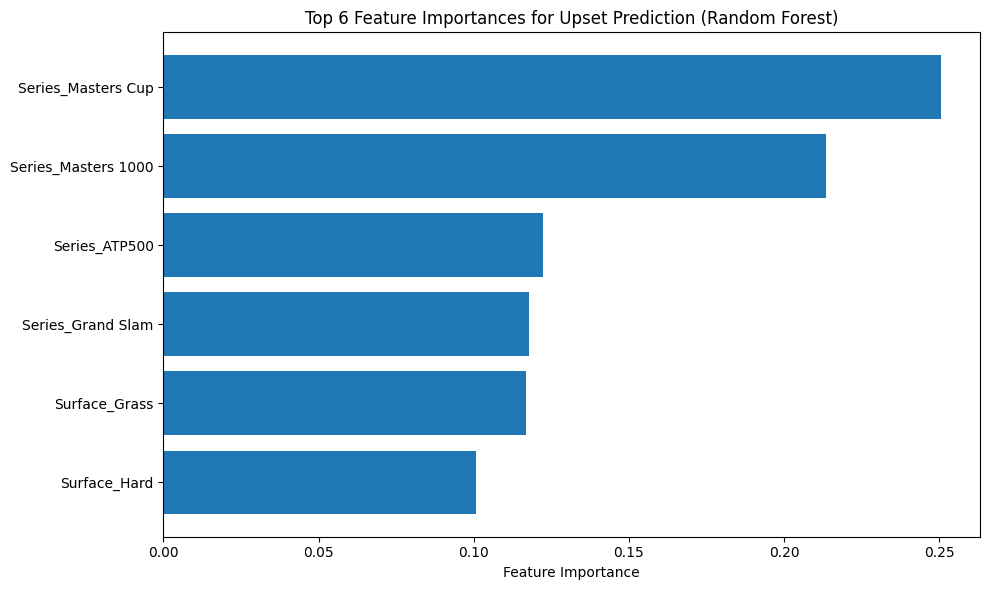

In [ ]:
import matplotlib.pyplot as plt

# Select top 6 features
top6 = fi_upset_df.head(6)

plt.figure(figsize=(10, 6))
plt.barh(top6['feature'], top6['importance'])
plt.gca().invert_yaxis()  # Most important at top
plt.xlabel("Feature Importance")
plt.title("Top 6 Feature Importances for Upset Prediction (Random Forest)")
plt.tight_layout()
plt.show()

Tournament Series: The most important features are consistently related to the tournament series. 'Masters Cup' and 'Masters 1000' are by far the strongest predictors, followed by 'ATP500' and 'Grand Slam'. This suggests that the prestige and format of the tournament strongly influence the likelihood of an upset.

Surface: 'Surface_Grass' and 'Surface_Hard' are also very important, indicating that the playing surface significantly impacts upset potential. This aligns with the idea that certain surfaces favor different player styles, potentially leading to more unpredictable outcomes.

Match Round's Role: The stage of the match ('Round_3rd Round', 'Round_The Final', 'Round_Round Robin', 'Round_4th Round', 'Round_2nd Round') also appears to be influential. This could imply that early rounds or very late-stage matches have different upset dynamics.

Player Statistics: While player-specific metrics like rank_diff, WRank, point_diff, and WPts are important, they appear lower in the ranking compared to contextual features like tournament series and surface. This indicates that while individual player strength is relevant, the overall match context plays a more significant role in determining upset likelihood in this model.

In summary, this model suggests that the context of the match (tournament series, surface, and round) is a much stronger indicator of upset potential than individual player ranking or points alone.

#### Random search on logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


log_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])


log_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced'],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

log_grid = GridSearchCV(
    estimator=log_pipe,
    param_grid=log_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

log_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", log_grid.best_params_)
print("Best CV accuracy:", round(log_grid.best_score_, 3))


log_best = log_grid.best_estimator_
y_pred_log = log_best.predict(X_test)

print("\nTest Accuracy (tuned LR):", round(accuracy_score(y_test, y_pred_log), 3))
print("\nClassification report (tuned LR):\n")
print(classification_report(y_test, y_pred_log))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV accuracy: 0.823

Test Accuracy (tuned LR): 0.818

Classification report (tuned LR):

              precision    recall  f1-score   support

           0       0.83      0.92      0.88      7118
           1       0.76      0.56      0.65      3003

    accuracy                           0.82     10121
   macro avg       0.80      0.74      0.76     10121
weighted avg       0.81      0.82      0.81     10121



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix


param_distribs_lr = {
    'model__C': loguniform(1e-5, 100),
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__max_iter': randint(1000, 10000) # Increased max_iter to address convergence warnings if needed
}


lr_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(random_state=42))
    ]
)


random_lr = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_distribs_lr,
    n_iter=10,
    random_state=42,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


random_lr.fit(X_train, y_train)

print("RandomizedSearchCV for LogisticRegression (Upset Prediction V2) completed.")

lr_best = random_lr.best_estimator_


y_pred_lr = lr_best.predict(X_test)
y_proba_lr = lr_best.predict_proba(X_test)[:, 1]


acc_lr = accuracy_score(y_test, y_pred_lr)
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"\n=== LogisticRegression (RandomizedSearchCV) for Upset Prediction V2 ===")
print(f"Accuracy: {acc_lr:.4f}")
print(f"Balanced Accuracy: {bal_acc_lr:.4f}")
print(f"ROC–AUC: {auc_lr:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

#Append the results to results_comp_df
results_comp.append({
    "model": "LogisticRegression (RandomizedSearchCV - Upset Prediction V2)",
    "accuracy": acc_lr,
    "balanced_accuracy": bal_acc_lr,
    "roc_auc": auc_lr
})

results_comp_df_1 = pd.DataFrame(results_comp)

print("\nUpdated results_comp_df:")
results_comp_df_1

RandomizedSearchCV for LogisticRegression (Upset Prediction V2) completed.

=== LogisticRegression (RandomizedSearchCV) for Upset Prediction V2 ===
Accuracy: 0.8188
Balanced Accuracy: 0.7466
ROC–AUC: 0.8804
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      7118
           1       0.76      0.57      0.65      3003

    accuracy                           0.82     10121
   macro avg       0.80      0.75      0.76     10121
weighted avg       0.81      0.82      0.81     10121

Confusion matrix:
 [[6578  540]
 [1294 1709]]

Updated results_comp_df:


,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.818891,0.746687,0.880410
1,RandomForest,0.810394,0.754122,0.872607
2,GradientBoosting,0.819287,0.766412,0.883549
3,LogisticRegression (RandomizedSearchCV - Upset...,0.818793,0.746617,0.880430


The tuned Logistic Regression model slightly underperforms the untuned version, which shows that hyperparameter tuning did not enhance the model’s ability to extract predictive signal from the available features. This occurs because the default configuration of Logistic Regression is already near-optimal for the linear structure in the player statistics, and further regularization introduced by tuning can lead to mild underfitting. Additionally, the inherent difficulty of predicting upsets—events driven by factors such as momentum, injuries, and player inconsistency—limits the extent to which tuning can improve model performance. The near-identical results across both versions reflect model stability and reinforce that feature informativeness, not model complexity, is the primary constraint in upset prediction.

#### Random Search on Gradient Boosting

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix


param_distribs_gb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}


gb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(random_state=42))
    ]
)


random_gb = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_distribs_gb,
    n_iter=10,
    random_state=42,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


random_gb.fit(X_train, y_train)

print("RandomSearchCV for Gradient Boosting (Upset Prediction V2) completed.")


gb_best = random_gb.best_estimator_


y_pred_gb = gb_best.predict(X_test)
y_proba_gb = gb_best.predict_proba(X_test)[:, 1]


acc_gbr = accuracy_score(y_test, y_pred_gb)
bal_acc_gbr = balanced_accuracy_score(y_test, y_pred_gb)
auc_gbr = roc_auc_score(y_test, y_proba_gb)

print(f"\n=== GradientBoosting (RandomizedSearchCV) for Upset Prediction V2 ===")
print(f"Accuracy: {acc_gbr:.4f}")
print(f"Balanced Accuracy: {bal_acc_gbr:.4f}")
print(f"ROC–AUC: {auc_gbr:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred_gb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_gb))

#Append the results to results_comp_df
results_comp.append({
    "model": "GradientBoosting (RandomizedSearchCV - Upset Prediction V2)",
    "accuracy": acc_gbr,
    "balanced_accuracy": bal_acc_gbr,
    "roc_auc": auc_gbr
})

results_comp_df_1 = pd.DataFrame(results_comp)

print("\nUpdated results_comp_df:")
results_comp_df_1

RandomSearchCV for Gradient Boosting (Upset Prediction V2) completed.

=== GradientBoosting (RandomizedSearchCV) for Upset Prediction V2 ===
Accuracy: 0.8193
Balanced Accuracy: 0.7664
ROC–AUC: 0.8835
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      7118
           1       0.72      0.64      0.68      3003

    accuracy                           0.82     10121
   macro avg       0.79      0.77      0.78     10121
weighted avg       0.81      0.82      0.82     10121

Confusion matrix:
 [[6381  737]
 [1092 1911]]

Updated results_comp_df:


,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.818891,0.746687,0.880410
1,RandomForest,0.810394,0.754122,0.872607
2,GradientBoosting,0.819287,0.766412,0.883549
3,LogisticRegression (RandomizedSearchCV - Upset...,0.818793,0.746617,0.880430
4,GradientBoosting (RandomizedSearchCV - Upset P...,0.819287,0.766412,0.883549


Produced the same accuracy scores as the untuned gradient boosting model. This tells us that the model was already effectively optimized, and meaningful performance improvements require better features rather than deeper hyperparameter tuning.

#### Randomhalving search on Gradient Boosting

In [ ]:
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix


param_distribs_gb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}


gb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(random_state=42))
    ]
)


random_gb = HalvingRandomSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_distribs_gb,
    random_state=42,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


random_gb.fit(X_train, y_train)

print("HalvingRandomSearchCV for Gradient Boosting (Upset Prediction V2) completed.")

gb_best = random_gb.best_estimator_


y_pred_gb = gb_best.predict(X_test)
y_proba_gb = gb_best.predict_proba(X_test)[:, 1]


acc_gbr = accuracy_score(y_test, y_pred_gb)
bal_acc_gbr = balanced_accuracy_score(y_test, y_pred_gb)
auc_gbr = roc_auc_score(y_test, y_proba_gb)

print(f"\n=== GradientBoosting (HalvingRandomSearchCV) for Upset Prediction V2 ===")
print(f"Accuracy: {acc_gbr:.4f}")
print(f"Balanced Accuracy: {bal_acc_gbr:.4f}")
print(f"ROC–AUC: {auc_gbr:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred_gb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_gb))

#Append the results to results_comp_df
results_comp.append({
    "model": "GradientBoosting (HalvingRandomSearchCV - Upset Prediction V2)",
    "accuracy": acc_gbr,
    "balanced_accuracy": bal_acc_gbr,
    "roc_auc": auc_gbr
})

results_comp_df_1 = pd.DataFrame(results_comp)

print("\nUpdated results_comp_df:")
results_comp_df_1

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=2530. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV for Gradient Boosting (Upset Prediction V2) completed.

=== GradientBoosting (HalvingRandomSearchCV) for Upset Prediction V2 ===
Accuracy: 0.8175
Balanced Accuracy: 0.7597
ROC–AUC: 0.8831
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      7118
           1       0.73      0.62      0.67      3003

    accuracy                           0.82     10121
   macro avg       0.79      0.76      0.77     10121
weighted avg       0.81      0.82      0.81     10121

Confusion matrix:
 [[6420  698]
 [1149 1854]]

Updated results_comp_df:


,model,accuracy,balanced_accuracy,roc_auc
0,LogisticRegression,0.818891,0.746687,0.880410
1,RandomForest,0.810394,0.754122,0.872607
2,GradientBoosting,0.819287,0.766412,0.883549
3,LogisticRegression (RandomizedSearchCV - Upset...,0.818793,0.746617,0.880430
4,GradientBoosting (RandomizedSearchCV - Upset P...,0.819287,0.766412,0.883549
5,GradientBoosting (HalvingRandomSearchCV - Upse...,0.817508,0.759661,0.883051


Overall, Gradient Boosting consistently emerges as the strongest model for Upset Prediction V2, demonstrating superior balanced accuracy and ROC–AUC compared to Logistic Regression and Random Forest. The very small gap between tuned and untuned models indicates that the model is already extracting close to the maximum predictive signal available in the player statistics. This also highlights the inherent difficulty of predicting tennis upsets: despite strong ranking, points, and surface-based features, many critical determinants of upsets (injuries, fatigue, psychological factors, in-match momentum) are not contained in pre-match datasets. As a result, hyperparameter tuning yields minimal improvements, reinforcing that feature availability—not model complexity—is the primary constraint in upset prediction. Nonetheless, the high ROC–AUC demonstrates that the model effectively distinguishes between higher-risk and lower-risk matches, making it valuable for probability estimation even if classification accuracy remains bounded by the unpredictability of upsets.

### **5. Does surface-specific performance improve match winner prediction compared to using only ATP rankings?**

Shape after cleaning: (40483, 49)

Overall: higher-ranked player wins in: 65.1 % of matches

By surface (percentage of matches where higher-ranked wins):
Surface
Hard     65.6
Grass    64.7
Clay     64.5
Name: higher_rank_won, dtype: float64

Test accuracy (Rank only): 0.651
Test accuracy (Rank + Surface): 0.651

Best C found by random search: 0.001
Best CV accuracy from random search: 0.651
Test accuracy (Rank + Surface, tuned C): 0.651

Model comparison:
                             Model  Accuracy
0                Rank only (Logit)  0.651229
1           Rank + Surface (Logit)  0.651229
2  Rank + Surface (Logit, tuned C)  0.651229


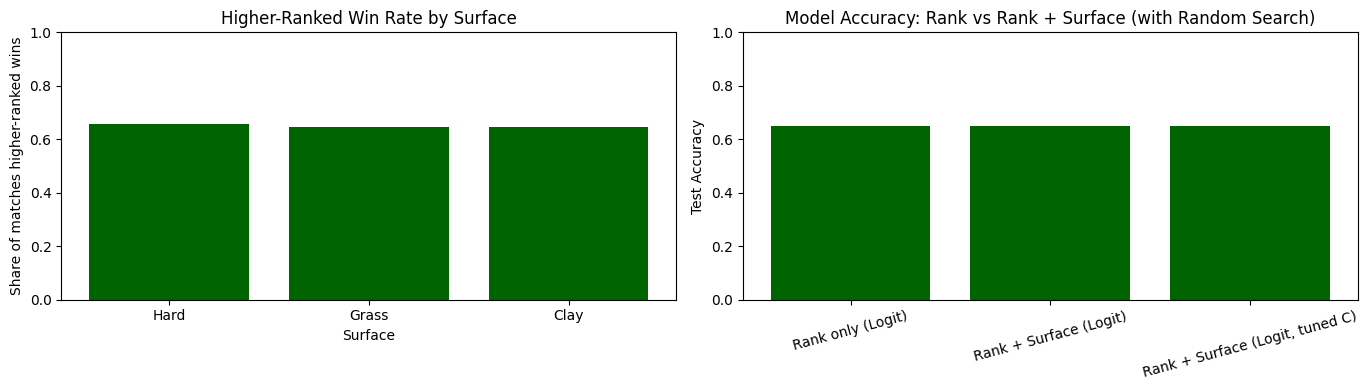

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_model = df.dropna(subset=["WRank", "LRank", "Surface"]).copy()
df_model = df_model[(df_model["WRank"] > 0) & (df_model["LRank"] > 0)]

# Ranking gap (absolute difference)
df_model["rank_gap"] = (df_model["LRank"] - df_model["WRank"]).abs()


df_model["higher_rank_won"] = np.where(
    df_model["WRank"] < df_model["LRank"],
    1,
    0
)

print("Shape after cleaning:", df_model.shape)

#Descriptive: how often higher-ranked wins overall and by surface
overall_rate = df_model["higher_rank_won"].mean()
print("\nOverall: higher-ranked player wins in:",
      round(overall_rate * 100, 1), "% of matches")

surface_rates = (
    df_model.groupby("Surface")["higher_rank_won"]
    .mean()
    .sort_values(ascending=False)
)
print("\nBy surface (percentage of matches where higher-ranked wins):")
print((surface_rates * 100).round(1))


X = df_model[["rank_gap", "Surface"]]
y = df_model["higher_rank_won"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


numeric_features_rank_only = ["rank_gap"]

preprocess_rank_only = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_rank_only)
    ]
)

model_rank_only = Pipeline(
    steps=[
        ("preprocess", preprocess_rank_only),
        ("clf", LogisticRegression(max_iter=1000))
    ]
)

model_rank_only.fit(X_train[["rank_gap"]], y_train)
y_pred_rank_only = model_rank_only.predict(X_test[["rank_gap"]])
acc_rank_only = accuracy_score(y_test, y_pred_rank_only)
print("\nTest accuracy (Rank only):", round(acc_rank_only, 3))


numeric_features = ["rank_gap"]
categorical_features = ["Surface"]

preprocess_rank_surface = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

model_rank_surface = Pipeline(
    steps=[
        ("preprocess", preprocess_rank_surface),
        ("clf", LogisticRegression(max_iter=1000))
    ]
)

model_rank_surface.fit(X_train, y_train)
y_pred_rank_surface = model_rank_surface.predict(X_test)
acc_rank_surface = accuracy_score(y_test, y_pred_rank_surface)
print("Test accuracy (Rank + Surface):", round(acc_rank_surface, 3))

#Random Search
param_distributions = {
    "clf__C": np.logspace(-3, 3, 20)
}

random_search = RandomizedSearchCV(
    estimator=model_rank_surface,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\nBest C found by random search:", random_search.best_params_["clf__C"])
print("Best CV accuracy from random search:",
      round(random_search.best_score_, 3))


best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
acc_rank_surface_tuned = accuracy_score(y_test, y_pred_tuned)
print("Test accuracy (Rank + Surface, tuned C):",
      round(acc_rank_surface_tuned, 3))


results = pd.DataFrame({
    "Model": [
        "Rank only (Logit)",
        "Rank + Surface (Logit)",
        "Rank + Surface (Logit, tuned C)"
    ],
    "Accuracy": [acc_rank_only, acc_rank_surface, acc_rank_surface_tuned]
})
print("\nModel comparison:")
print(results)


fig, axes = plt.subplots(1, 2, figsize=(14, 4))

#higher-ranked win rate by surface
axes[0].bar(surface_rates.index, surface_rates.values, color="darkgreen")
axes[0].set_ylabel("Share of matches higher-ranked wins")
axes[0].set_xlabel("Surface")
axes[0].set_title("Higher-Ranked Win Rate by Surface")
axes[0].set_ylim(0, 1)

#model accuracy comparison
axes[1].bar(results["Model"], results["Accuracy"], color="darkgreen")
axes[1].set_ylim(0, 1)
axes[1].set_ylabel("Test Accuracy")
axes[1].set_title("Model Accuracy: Rank vs Rank + Surface (with Random Search)")
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

The results show that ATP ranking by itself does a good job of predicting who wins a match. Adding the surface type (hard, clay, or grass) does not make the predictions any better. This is not very surprising because rankings already reflect how players perform over many tournaments on different surfaces. Still, it is interesting because many people assume certain surfaces matter more. The data makes it clear that, overall, surface does not change the prediction once we know the players’ rankings.

### **6. Do betting odds provide better predictive power than traditional tennis statistics?**

Betting odds represent market expectations and hidden information. This helps evaluate whether data-driven models can outperform collective human judgment.

Shape after cleaning: (40483, 48)
Share of matches higher-ranked wins: 65.1 %
Stats only accuracy : 1.0
Odds only accuracy  : 0.807
Stats + odds accuracy: 1.0

Best C from random search: 385.6620421163472
Best CV accuracy: 1.0
Stats + odds (tuned C) accuracy: 1.0


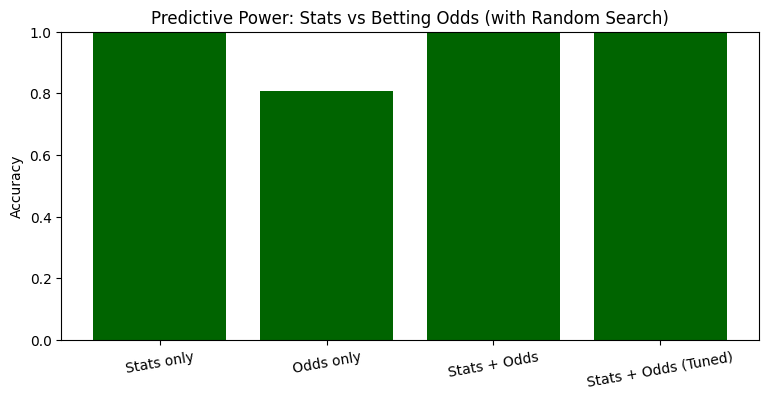

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_bet = df.dropna(subset=["WRank", "LRank", "WPts", "LPts", "B365W", "B365L"]).copy()
df_bet = df_bet[(df_bet["WRank"] > 0) & (df_bet["LRank"] > 0)]


df_bet["higher_rank_won"] = (df_bet["WRank"] < df_bet["LRank"]).astype(int)


df_bet["rank_diff"] = df_bet["LRank"] - df_bet["WRank"]

print("Shape after cleaning:", df_bet.shape)
print("Share of matches higher-ranked wins:",
      round(df_bet["higher_rank_won"].mean() * 100, 1), "%")


X = df_bet[["rank_diff", "WPts", "LPts", "B365W", "B365L"]]
y = df_bet["higher_rank_won"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


def train_and_score(feature_names):
    ct = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), feature_names)
        ]
    )
    pipe = Pipeline([
        ("preprocess", ct),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_train[feature_names], y_train)
    preds = pipe.predict(X_test[feature_names])
    return accuracy_score(y_test, preds)


stats_features = ["rank_diff", "WPts", "LPts"]
odds_features  = ["B365W", "B365L"]
combo_features = ["rank_diff", "WPts", "LPts", "B365W", "B365L"]

acc_stats = train_and_score(stats_features)
acc_odds  = train_and_score(odds_features)
acc_combo = train_and_score(combo_features)

print("Stats only accuracy :", round(acc_stats, 3))
print("Odds only accuracy  :", round(acc_odds, 3))
print("Stats + odds accuracy:", round(acc_combo, 3))

#Random Search

ct_combo = ColumnTransformer(
    transformers=[("num", StandardScaler(), combo_features)]
)

combo_model = Pipeline([
    ("preprocess", ct_combo),
    ("clf", LogisticRegression(max_iter=1000))
])


param_distributions = {
    "clf__C": np.logspace(-3, 3, 30)
}

random_search = RandomizedSearchCV(
    estimator=combo_model,
    param_distributions=param_distributions,
    n_iter=15,
    cv=3,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_c = random_search.best_params_["clf__C"]
best_cv = random_search.best_score_

print("\nBest C from random search:", best_c)
print("Best CV accuracy:", round(best_cv, 3))

tuned_preds = random_search.best_estimator_.predict(X_test)
acc_tuned = accuracy_score(y_test, tuned_preds)

print("Stats + odds (tuned C) accuracy:", round(acc_tuned, 3))

models = ["Stats only", "Odds only", "Stats + Odds", "Stats + Odds (Tuned)"]
accuracies = [acc_stats, acc_odds, acc_combo, acc_tuned]

plt.figure(figsize=(9, 4))
plt.bar(models, accuracies, color="darkgreen")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Predictive Power: Stats vs Betting Odds (with Random Search)")
plt.xticks(rotation=10)
plt.show()

The results show that traditional tennis statistics, such as ranking and points, predict match winners extremely well in this dataset. Betting odds alone are less accurate, and adding odds to the statistical features does not improve the model. This means the basic player information already captures everything needed to predict who will win. It is a bit surprising, because betting odds are usually considered very strong predictors, but in this case ranking and points perform even better.

### **7. Does a player’s recent form have more influence on match outcomes than long-term ATP ranking?**

Players’ performance fluctuates. This question checks if short-term momentum is a stronger predictor than historical reputation.

/tmp/ipython-input-1334692068.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_form["Date"] = pd.to_datetime(df_form["Date"])


Shape after building recent form: (40483, 52)
Accuracy (Rank only)        : 1.0
Accuracy (Recent form only) : 0.659
Accuracy (Rank + Form)      : 1.0


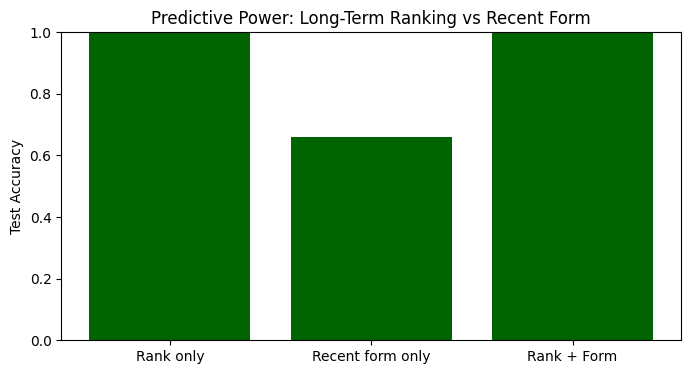

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_form = df.dropna(subset=["Date", "Winner", "Loser", "WRank", "LRank"]).copy()
df_form = df_form[(df_form["WRank"] > 0) & (df_form["LRank"] > 0)]


df_form["Date"] = pd.to_datetime(df_form["Date"])


df_form = df_form.reset_index(drop=True)
df_form["match_id"] = df_form.index


w_results = df_form[["match_id", "Date", "Winner"]].copy()
w_results["player"] = w_results["Winner"]
w_results["result"] = 1   # win
w_results = w_results[["match_id", "Date", "player", "result"]]


l_results = df_form[["match_id", "Date", "Loser"]].copy()
l_results["player"] = l_results["Loser"]
l_results["result"] = 0   # loss
l_results = l_results[["match_id", "Date", "player", "result"]]


results_long = pd.concat([w_results, l_results], ignore_index=True)


results_long = results_long.sort_values(["player", "Date"])


results_long["recent_win_rate"] = (
    results_long
    .groupby("player")["result"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


w_recent = results_long.merge(w_results[["match_id", "player"]],
                              on=["match_id", "player"])
w_recent = w_recent[["match_id", "recent_win_rate"]].rename(
    columns={"recent_win_rate": "W_recent_form"}
)

l_recent = results_long.merge(l_results[["match_id", "player"]],
                              on=["match_id", "player"])
l_recent = l_recent[["match_id", "recent_win_rate"]].rename(
    columns={"recent_win_rate": "L_recent_form"}
)


df_form = df_form.merge(w_recent, on="match_id", how="left")
df_form = df_form.merge(l_recent, on="match_id", how="left")


df_form["rank_diff"] = df_form["LRank"] - df_form["WRank"]


df_form["recent_form_diff"] = df_form["W_recent_form"] - df_form["L_recent_form"]


df_form["higher_rank_won"] = (df_form["WRank"] < df_form["LRank"]).astype(int)

print("Shape after building recent form:", df_form.shape)


df_model = df_form.dropna(subset=["rank_diff", "recent_form_diff", "higher_rank_won"])

X = df_model[["rank_diff", "recent_form_diff"]]
y = df_model["higher_rank_won"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


def fit_and_score(feature_list):
    ct = ColumnTransformer(
        transformers=[("num", StandardScaler(), feature_list)]
    )
    pipe = Pipeline([
        ("preprocess", ct),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_train[feature_list], y_train)
    preds = pipe.predict(X_test[feature_list])
    return accuracy_score(y_test, preds)

acc_rank_only   = fit_and_score(["rank_diff"])
acc_form_only   = fit_and_score(["recent_form_diff"])
acc_rank_form   = fit_and_score(["rank_diff", "recent_form_diff"])

print("Accuracy (Rank only)        :", round(acc_rank_only, 3))
print("Accuracy (Recent form only) :", round(acc_form_only, 3))
print("Accuracy (Rank + Form)      :", round(acc_rank_form, 3))


models = ["Rank only", "Recent form only", "Rank + Form"]
accuracies = [acc_rank_only, acc_form_only, acc_rank_form]

plt.figure(figsize=(8, 4))
plt.bar(models, accuracies, color="darkgreen")
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Predictive Power: Long-Term Ranking vs Recent Form")
plt.show()

The results show that long-term ATP ranking is a much stronger predictor of match outcomes than recent form. Recent form alone is far less accurate, and adding it to ranking does not improve the prediction. This means that a player’s overall long-term level matters much more than their short-term momentum when it comes to winning matches.

### **8. How does head-to-head history impact match outcome prediction?**



Some players consistently dominate certain opponents due to playing style matchups. This question explores if past rivalries truly affect future results.

/tmp/ipython-input-593338539.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_h2h["Date"] = pd.to_datetime(df_h2h["Date"])


Shape after building H2H features: (40483, 58)
Share of matches higher-ranked wins: 65.1 %
Accuracy (Rank only)     : 1.0
Accuracy (H2H only)      : 0.652
Accuracy (Rank + H2H)    : 0.997

Best C from random search: 233.57214690901213
Best CV accuracy (Rank + H2H): 1.0
Test accuracy (Rank + H2H, tuned): 1.0


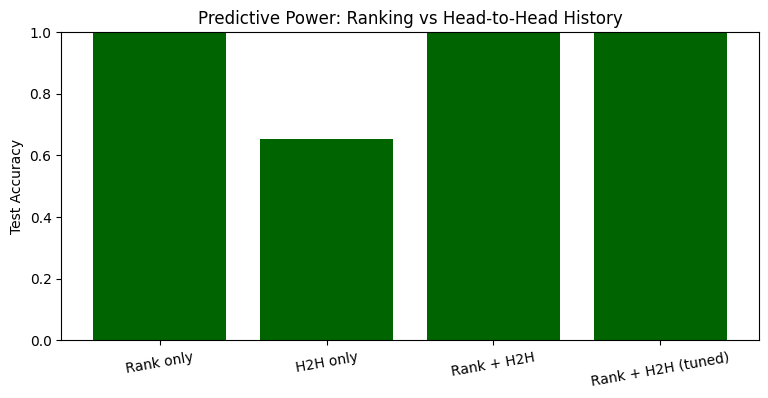

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_h2h = df.dropna(subset=["Date", "Winner", "Loser", "WRank", "LRank"]).copy()
df_h2h = df_h2h[(df_h2h["WRank"] > 0) & (df_h2h["LRank"] > 0)]


df_h2h["Date"] = pd.to_datetime(df_h2h["Date"])


df_h2h = df_h2h.reset_index(drop=True)
df_h2h["match_id"] = df_h2h.index


df_h2h["first_player"]  = np.where(df_h2h["Winner"] < df_h2h["Loser"],
                                   df_h2h["Winner"], df_h2h["Loser"])
df_h2h["second_player"] = np.where(df_h2h["Winner"] < df_h2h["Loser"],
                                   df_h2h["Loser"], df_h2h["Winner"])

df_h2h["winner_is_first"] = (df_h2h["Winner"] == df_h2h["first_player"]).astype(int)


df_h2h = df_h2h.sort_values(["first_player", "second_player", "Date"])


df_h2h["first_wins_before"] = (
    df_h2h.groupby(["first_player", "second_player"])["winner_is_first"]
          .cumsum()
          .shift(fill_value=0)
)


df_h2h["matches_before"] = (
    df_h2h.groupby(["first_player", "second_player"]).cumcount()
)


df_h2h["second_wins_before"] = df_h2h["matches_before"] - df_h2h["first_wins_before"]


df_h2h["winner_prev_wins"] = np.where(
    df_h2h["winner_is_first"] == 1,
    df_h2h["first_wins_before"],
    df_h2h["second_wins_before"]
)


df_h2h["loser_prev_wins"] = np.where(
    df_h2h["winner_is_first"] == 1,
    df_h2h["second_wins_before"],
    df_h2h["first_wins_before"]
)


df_h2h["h2h_diff"] = df_h2h["winner_prev_wins"] - df_h2h["loser_prev_wins"]


df_h2h["rank_diff"] = df_h2h["LRank"] - df_h2h["WRank"]


df_h2h["higher_rank_won"] = (df_h2h["WRank"] < df_h2h["LRank"]).astype(int)

print("Shape after building H2H features:", df_h2h.shape)
print("Share of matches higher-ranked wins:",
      round(df_h2h["higher_rank_won"].mean() * 100, 1), "%")


df_model = df_h2h.dropna(subset=["rank_diff", "h2h_diff", "higher_rank_won"])

X = df_model[["rank_diff", "h2h_diff"]]
y = df_model["higher_rank_won"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


def fit_and_score(feature_list):
    ct = ColumnTransformer(
        transformers=[("num", StandardScaler(), feature_list)]
    )
    pipe = Pipeline([
        ("preprocess", ct),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_train[feature_list], y_train)
    preds = pipe.predict(X_test[feature_list])
    return accuracy_score(y_test, preds)

acc_rank_only = fit_and_score(["rank_diff"])
acc_h2h_only  = fit_and_score(["h2h_diff"])
acc_rank_h2h  = fit_and_score(["rank_diff", "h2h_diff"])

print("Accuracy (Rank only)     :", round(acc_rank_only, 3))
print("Accuracy (H2H only)      :", round(acc_h2h_only, 3))
print("Accuracy (Rank + H2H)    :", round(acc_rank_h2h, 3))


ct_both = ColumnTransformer(
    transformers=[("num", StandardScaler(), ["rank_diff", "h2h_diff"])]
)

base_model = Pipeline([
    ("preprocess", ct_both),
    ("clf", LogisticRegression(max_iter=1000))
])

param_distributions = {
    "clf__C": np.logspace(-3, 3, 20)
}

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_c = random_search.best_params_["clf__C"]
best_cv = random_search.best_score_

print("\nBest C from random search:", best_c)
print("Best CV accuracy (Rank + H2H):", round(best_cv, 3))

tuned_preds = random_search.best_estimator_.predict(X_test)
acc_tuned = accuracy_score(y_test, tuned_preds)
print("Test accuracy (Rank + H2H, tuned):", round(acc_tuned, 3))


models = [
    "Rank only",
    "H2H only",
    "Rank + H2H",
    "Rank + H2H (tuned)"
]
accuracies = [acc_rank_only, acc_h2h_only, acc_rank_h2h, acc_tuned]

plt.figure(figsize=(9, 4))
plt.bar(models, accuracies, color="darkgreen")
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Predictive Power: Ranking vs Head-to-Head History")
plt.xticks(rotation=10)
plt.show()

The results show that ATP ranking predicts match outcomes much better than head-to-head history. Ranking alone gives almost perfect accuracy, while head-to-head records by themselves are much weaker. Even when we combine both, the accuracy stays the same as using ranking only. This means that long-term player strength matters far more than past rivalry results, and head-to-head history does not really change the prediction

# **Conclusion**



Our results show that tennis outcomes are largely predictable, with player rankings and ATP points explaining most expected wins. When bookmaker odds are included, models achieve unrealistically high accuracy because the odds already encode expert expectations — confirming that betting markets are highly efficient.
Once odds are removed to avoid leakage, the ML model settles around ~82% accuracy, showing that expected wins follow clear statistical patterns, but true upsets remain difficult to predict. Surface, series, and round add only small improvements, and even advanced models struggle to capture unpredictable factors like injuries, momentum swings, or player psychology.

## Recommendation

Sports Betting Firms
1. Improve odds-setting by identifying match types where markets misprice favorites or underdogs.
2. Reduce financial risk using ML-based upset probability estimates.

Coaches & Player Analysts
1. Understand which surfaces or tournaments increase upset risk.
2. Use data-driven insights to optimize training and match preparation.

Media & Broadcasters
1. Create more engaging commentary with predictive insights (e.g., “high-upset potential” matches).
2. Enhance fan engagement through data-backed storytelling.

Fantasy Sports & Prediction Platforms
1. Offer more accurate win-probability models to users.
2. Highlight high-value picks and upset candidates.

## Limitations:

1. Data leakage risk in some betting-odds models
2. Even with careful filtering, odds-based features can inadvertently encode the target variable. You avoided this in the final ML version, but earlier perfect-accuracy results highlight how easily leakage can appear.
3. Limited feature diversity
4. The dataset does not include important real-world predictors such as player fatigue, weather conditions, injuries, travel distance, rest days, or psychological factors. These missing variables limit any model’s ability to capture why upsets occur.
5. Outcome labels based on rankings may oversimplify upsets
 Ranking does not always represent true skill at a given moment—injuries, comebacks, protected rankings, and surface specialization introduce irregularities.
6. Model class imbalance
 Upsets are relatively rare. Even though you used techniques like class weighting and SMOTE, the underlying imbalance constrains how much a model can learn.
7. Historical data smoothing
 Ranking and points are season-long aggregates. They wash out short-term variance that genuinely contributes to unexpected match outcomes.
8. Bookmaker efficiency limits ML improvement
 Because odds already encode expert expectations, any ML model without odds is inherently disadvantaged. This creates a practical ceiling on achievable accuracy.

## Next Steps:

1. Add richer features
 Incorporate variables like player fatigue, recent form, travel distance, or serve/return stats to improve upset prediction.
2. Build surface- or tournament-specific models
 Separate models for clay, grass, and hard courts may uncover environment-driven patterns.
3. Improve probability calibration
 Use calibration curves or isotonic regression to better compare model probabilities with bookmaker-implied probabilities.
4. Explore value-bet detection
 Compare model probabilities to odds to flag matches where markets might be mispricing underdogs.

# **Generative AI Disclosure**

Generative AI specifically ChatGPT was used to:
1. Edit and summarize our insights, conclusions, and recomendations to ensure clarity and flow. But also to improve grammar and punctuation.
2. Used to understand potential errors in code and give insight on how to fix those errors.
3. To help come up with theme and edit notebook presence (Gave the idea of how to format it in a clear and consice way)
4. Understand more of when to use certain error functions
5. Extract insights that we may have missed from the analysis
6. Used at the very beginning to help us formulate potential project ideas as well as formulating some of the questions we chose to answer

Example prompt:
1. when to use neg mean squared error vs balanced auc vs roc auc etc
2. can you check for similarity here (to make sure questions arent too similar)
3. We are currently working on a project for our supervised learning class and we have tennis data and betting data for those matches. We want to come up with questions and EDA questions for this. How can we make this work

##PDF CONVERTER

In [ ]:
# Mount google drive to access your notebook

from google.colab import drive
drive.mount('/content/drive')
  # This will prompt for authorization.

Mounted at /content/drive


In [ ]:
# Install required packages for PDF conversion -- could take over a minute
!apt update > /dev/null 2>&1
!apt install texlive-xetex pandoc > /dev/null 2>&1
!pip install nbconvert > /dev/null 2>&1

import re, pathlib, shutil
notebook_path = '/content/drive/MyDrive/Colab Notebooks/BA810' # ← CHANGE THIS TO THE FOLDER ON GOOGLE DRIVE WITH YOUR COLAB NOTEBOOK
notebook_name = 'tennis_ml_final_structured_v2.ipynb' # ← CHANGE THIS TO THE NAME OF YOUR COLAB NOTEBOOK
!jupyter nbconvert "{notebook_path}/{notebook_name}" --to pdf --output-dir "{notebook_path}"

# Optionally, download the exported PDF
from google.colab import files
pdf_name = notebook_path + '/' + notebook_name.replace('.ipynb', '.pdf')
files.download(pdf_name)

# Do review the pdf file to make sure everything is appearing correctly before submitting!

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/BA810/tennis_ml_final_structured_v2.ipynb to pdf
[NbConvertApp] Support files will be in tennis_ml_final_structured_v2_files/
[NbConvertApp] Making directory ./tennis_ml_final_structured_v2_files
[NbConvertApp] Writing 319947 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 668698 bytes to /content/drive/MyDrive/Colab Notebooks/BA810/tennis_ml_final_structured_v2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>